## BART Comparative Station Analysis

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn.objects as so
if not os.path.exists("images"): 
    os.mkdir("images")
import geopy.distance

In [85]:
#background mapping doc
station_abr_merge = pd.pandas.read_csv('station_abr_merge_final.csv', header = 0, index_col=0)
station_abr_merge['Abbr'] = station_abr_merge['Abbr'].str.upper()
station_abr_merge.head()

Station Name Two-Letter Station Code  Abbr
0              Richmond                      RM  RICH
1  El Cerrito Del Norte                      EN  DELN
2      El Cerrito Plaza                      EP  PLZA
3        North Berkeley                      NB  NBRK
4              Berkeley                      BK  DBRK

In [86]:
# LL = pd.read_csv('Bart Long Lat - Sheet1.csv')
LL = pd.read_csv('Bart Long Lat - Sheet2.csv')
LL.Long = -LL.Long
LL.Station = LL.Station.str.strip()
LL.head()

Station      Long      Lat
0    12TH -122.2714  37.8037
1    16TH -122.4196  37.7650
2    19TH -122.2686  37.8083
3    24TH -122.4181  37.7524
4    ASHB -122.2700  37.8528

In [4]:
#Import 2019 Preprocessing Destination Data. 

df = pd.read_csv('date-hour-soo-dest-2019.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['Month'] = df['Date'].dt.month
df['Month Name'] = df['Date'].dt.month_name()
destination2019 = df.groupby(['Month Name','Month','Destination Station'])['Trip Count'].sum(
).reset_index().sort_values(by=['Month']).reset_index().drop(columns = ['index']).rename(columns = {'Destination Station':'Station',
                                                                                                          'Trip Count':'2019'})
destination2019.head(2)

Month Name  Month Station    2019
0    January      1    CONC  131512
1    January      1    LAFY   83214

In [5]:
#Import 2019 Preprocessing Origin Data. 
df = pd.read_csv('date-hour-soo-dest-2019.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['Month'] = df['Date'].dt.month
df['Month Name'] = df['Date'].dt.month_name()
# df['Year'] = df['Date'].dt.year
origin2019 = df.groupby(['Month Name','Month','Origin Station'])['Trip Count'].sum(
).reset_index().sort_values(by=['Month']).reset_index().drop(columns = ['index']).rename(columns = 
                                                                                         {'Origin Station':'Station','Trip Count':'2019'})
origin2019.head(2)

Month Name  Month Station    2019
0    January      1    CONC  131502
1    January      1    LAFY   81229

In [6]:
#2019 concatenation and output
station_19 = pd.concat([destination2019,origin2019])
station_19 = station_19.groupby(['Month Name','Month','Station'])[['2019']].sum().reset_index()
station_19.head(2)

Month Name  Month Station    2019
0      April      4    12TH  666117
1      April      4    16TH  665159

In [7]:
#2023 Import
station_23_stitch = []
for k,v in {'May':'202305','June':'202306','July':'202307','August':'202308','September':'202309','October':'202310','November':'202311','December':'202312'}.items():
    tdf = pd.pandas.read_excel('ridership_2023/Ridership_' + v + '.xlsx', header = 1, index_col=0, sheet_name = 'Total Trips OD')
    tdf = pd.concat([tdf.T[['Entries']].reset_index().drop([tdf.T[['Entries']].shape[0]-1]),
           tdf[['Exits']].reset_index().drop([tdf[['Exits']].shape[0]-1]).rename(columns = {'Exits':'Entries'})]
         ).groupby('index').sum().reset_index().rename(columns = {'index':'Station','Entries':'Trip Count'})
    tdf['Month Name'] = k
    tdf['Month'] = dt.datetime.strptime(v, "%Y%m").month
    tdf['Station'] = tdf['Station'].astype(str)
    tdf = tdf.merge(station_abr_merge, how = 'left', left_on = 'Station',right_on = 'Two-Letter Station Code')
    tdf = tdf[['Month Name','Month','Abbr','Trip Count']].rename(columns = {'Abbr': 'Station','Trip Count':'2023'})
    station_23_stitch.append(tdf)

In [8]:
#2024 Import
for k,v in {'January':'202401','February':'202402','March':'202403','April':'202404'}.items():
    ddf = pd.pandas.read_excel('ridership_2023/Ridership_' + v + '.xlsx', header = 1, index_col=0, sheet_name = 'Total Trips',skiprows=3)
    GT = ddf.T[['Grand Total']].drop(['Unnamed: 51'])
    Un51 = ddf[['Unnamed: 51']].drop(['Grand Total']).rename(columns = {'Unnamed: 51':'Grand Total'})
    tdf = pd.concat([GT,Un51]).reset_index().groupby('index')[['Grand Total']].sum().reset_index().rename(columns= {'index':'Station','Grand Total':'Trip Count'})
    tdf['Month Name'] = k
    tdf['Month'] = dt.datetime.strptime(v, "%Y%m").month
    tdf['Station'] = tdf['Station'].astype(str)
    tdf = tdf.merge(station_abr_merge, how = 'left', left_on = 'Station',right_on = 'Two-Letter Station Code')
    tdf = tdf[['Month Name','Month','Abbr','Trip Count']].rename(columns = {'Abbr': 'Station','Trip Count':'2023'})
    tdf[['2023']].convert_dtypes()
    station_23_stitch.append(tdf)

In [9]:
#2023 + 2024
station_stitch = pd.concat(station_23_stitch)
station_stitch.head(2)

Month Name  Month Station      2023
0        May      5    12TH  234249.0
1        May      5    16TH  301411.0

In [10]:
#2019 + 2023 + 2024
final_st_merge = station_19.merge(station_stitch, how = 'left', 
                                  left_on = ['Month Name','Month','Station'], 
                                  right_on=['Month Name','Month','Station'])
station_19v23 = final_st_merge.groupby('Station')[['2019','2023']].sum().reset_index()
station_19v23['Type'] = 'Other Stations'
station_19v23.loc[station_19v23['Station'].isin(['SFIA','OAKL']),'Type'] = 'Airport'
station_19v23.loc[station_19v23['Station'].isin(['EMBR','POWL','CIVC','MONT']),'Type'] = 'SF Downtown' 
station_19v23.head(2)

Station     2019       2023            Type
0    12TH  7759318  2839602.0  Other Stations
1    16TH  7739460  3501328.0  Other Stations

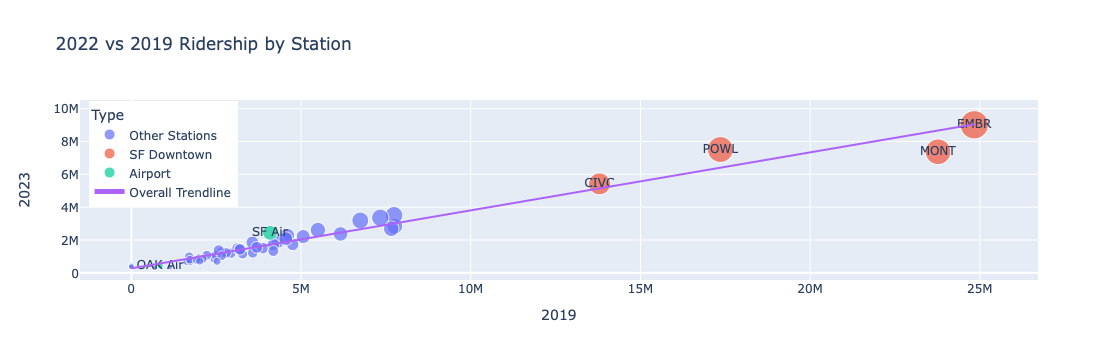

In [11]:
# Bounceback Analysis
texts = [''] * 50
texts[18] = 'EMBR'
texts[28] = 'MONT'
texts[37] = 'POWL'
texts[10] = 'CIVC'
texts[42] = 'SF Air'
texts[31] = 'OAK Air'

ratio_scat = px.scatter(station_19v23,
                         x="2019", 
                         y="2023",
                         labels={"Trip Count_2019":"2019","Trip Count_2022":"2022"},
                        color = "Type",
                         trendline="ols", trendline_scope="overall",
                        text = texts,
                        hover_data=["Station"],
                        size="2023", size_max=20,
                         title = "2022 vs 2019 Ridership by Station")
# ratio_scat.add_trace(
#     go.Scatter(x=station_19v23['2019'], y=station_19v23['2019'], name="100% Bounceback", line_shape='linear')
# )
ratio_scat.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
ratio_scat.update_layout(hovermode="x")
# ratio_scat.update_yaxes(range = [0,40000000])
ratio_scat.write_image("images/ratio_scat.png")
ratio_scat.write_image("images/ratio_scat.svg")
ratio_scat.show()

Station Performance:
- SF Downtown are the busiest stations. 
- POWL is the hub of shopping and retail.
- MONT underperforms. MONT is the hub of corporate offices / Financial District.
- EMBR and CIVC are on the trendline. EMBR is a mix of offices and tourism which CIVC is all SF City Jobs and City Hall. 

Regression line is .35 --> bounceback is 35%

Other Data points of note: SF Airport


In [12]:
#Downtown Bounceback stats and calculations

station_19v23['Bounceback'] = station_19v23['2023']/station_19v23['2019']
# station_19v23 = station_19v23.sort_values(by = 'Bounceback',ascending = False).drop([8,27])
station_19v23['2019 Rank'] = station_19v23['2019'].rank(ascending = False)
station_19v23['2023 Rank'] = station_19v23['2023'].rank(ascending = False)
station_19v23[station_19v23['Station'].isin(['MONT','EMBR','CIVC','POWL'])]

Station      2019       2023         Type  Bounceback  2019 Rank  2023 Rank
10    CIVC  13792756  5417672.0  SF Downtown    0.392791        4.0        4.0
18    EMBR  24836028  9012387.0  SF Downtown    0.362876        1.0        1.0
28    MONT  23767969  7371293.0  SF Downtown    0.310136        2.0        3.0
37    POWL  17355760  7507818.0  SF Downtown    0.432584        3.0        2.0

In [13]:
# Share of total volume for Airport, SF Downtown and Other Stations
dt_volume = station_19v23.groupby('Type')[['2019','2023']].agg('sum')
dt_volume['2019_Vol'] = dt_volume['2019']/dt_volume['2019'].sum()
dt_volume['2023_Vol'] = dt_volume['2023']/dt_volume['2023'].sum()
dt_volume

2019        2023  2019_Vol  2023_Vol
Type                                                     
Airport           4937473   2860337.0  0.020814  0.029367
Other Stations  152529224  65229870.0  0.642988  0.669715
SF Downtown      79752513  29309170.0  0.336198  0.300917

## Station Route Heat Map

In [14]:
#Import 2023, Not using the endput but keep
df202312 = pd.read_excel('ridership_2023/Ridership_202312.xlsx', header = 1,index_col=0,sheet_name = 'Total Trips OD')
df202312 = df202312.drop('Entries').drop(columns = 'Exits')
df202312.columns = pd.DataFrame(df202312.columns.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
df202312.index = pd.DataFrame(df202312.index.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
df202312.head(2)

RICH  DELN  PLZA  NBRK  DBRK  ASHB  MCAR  19TH  12TH  LAKE  ...  SBRN  \
RICH   482  1690  1540   847  5216  1237  1891  1394  1642   484  ...   302   
DELN  1758   523  1465  1100  7445  1400  2554  3062  3994   843  ...   403   

      SFIA  MLBR  WDUB  OAKL  WARM  MLPT  BERY  PCTR  ANTC  
RICH  1090   315    57   203   256   206   212   103   239  
DELN  1775   612   161   582   460   375   510    64   229  

[2 rows x 50 columns]

In [15]:
df202401 = pd.read_excel('ridership_2023/Ridership_202401.xlsx', header = 1,index_col=0,skiprows=3,sheet_name = 'Total Trips')
df202401 = df202401.drop('Grand Total').drop(columns = 'Unnamed: 51')
df202401.columns = pd.DataFrame(df202401.columns.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
df202401.index = pd.DataFrame(df202401.index.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 'Exit Station Two-Letter Code', right_on='Two-Letter Station Code')['Abbr'].to_list()
df202401['Month'] = 'Jan'
df202401.reset_index()

index  RICH  DELN  PLZA  NBRK   DBRK  ASHB   MCAR   19TH   12TH  ...  \
0   RICH   425  1800  1556   870   5754  1216   1971   1521   1881  ...   
1   DELN  1822   545  1712  1258   9138  1528   2711   3441   4608  ...   
2   PLZA  1651  1528   219   884   7677  1167   1620   2357   2636  ...   
3   NBRK   884  1056   878   266   2015   648   1041   1966   1865  ...   
4   DBRK  6545  9449  7961  2310   1083  3814   3845   5462   5642  ...   
5   ASHB  1189  1484  1260   815   3710   297    982   2006   2147  ...   
6   MCAR  2306  2615  1423   987   3854  1073    554   2221   2587  ...   
7   19TH  1700  3598  2307  2055   5049  2138   2290    568    552  ...   
8   12TH  1993  4282  2526  1897   5024  2019   2478    543    662  ...   
9   LAKE   521   920   629   498   2225   636    680    349    339  ...   
10  FTVL  1358  1586   679   753   3026  1362   2302   1623   1641  ...   
11  COLS  1054   872   247   338   1375   506   1462   1242   1570  ...   
12  SANL   614   860   369   476   1788   574   1452   1940   2972  ...   
13  BAYF   304   438   282   243   1353   344    926   1390   2168  ...   
14  HAYW   402   711   232   293   1253   362    860   1393   1920  ...   
15  SHAY   225   258   115    86    890   176    552    729   1164  ...   
16  UCTY   169   440   209   154   1572   214    670   1323   1941  ...   
17  FRMT   239   455   194   235   1403   278    667   1286   1538  ...   
18  CONC   338   406   201   244   1109   229   1837   1781   2078  ...   
19  PHIL   162   257   248   170   1075   266   1453   1859   2547  ...   
20  WCRK   385   416   301   357   1394   276   1778   2379   2585  ...   
21  LAFY   228   195   140   120    593   137    740   1302   1149  ...   
22  ORIN   161   161   121    90    385    63    473    883   1048  ...   
23  ROCK   395   477   421   240    465   197   1034   2141   1922  ...   
24  WOAK   527   451   126   325    986   433    819   1004   1263  ...   
25  EMBR  5037  9726  6223  7162  10268  6643  10944  15067  14923  ...   
26  MONT  4926  8516  5171  5517   7889  5793   9102  11317  10671  ...   
27  POWL  5485  8750  3706  3320   7426  3723   6981   8197   9946  ...   
28  CIVC  3715  6234  3210  3699   5272  4367   7243   7969   6955  ...   
29  16TH  2310  2887  1137  1774   3275  2171   4340   4780   4106  ...   
30  24TH  2431  2261   960  1154   2883  1333   2802   3227   3104  ...   
31  GLEN   608   860   384   468   1583   409    964   1589   1610  ...   
32  BALB   885  1057   342   358    925   407    885   1134   1572  ...   
33  DALY   785  1250   415   250   1034   276    839   1140   1537  ...   
34  COLM   287   293    88   102    371    85    163    355    628  ...   
35  CAST    91   120    67    37    389    80    192    363    351  ...   
36  DUBL   159   258   143   140   1010   191    589   1126   1791  ...   
37  NCON    57    42    68    28    207    20    345    426    719  ...   
38  PITT   287   201    71    81    706   105   1608    975   1753  ...   
39  SSAN   242   424    91    71    402    92    208    513    784  ...   
40  SBRN   307   369   138    71    421   139    326    581    749  ...   
41  SFIA   930  1263   755  1175   1948   702   1248   1037   1461  ...   
42  MLBR   341   661   227   256   1218   290    440    609    899  ...   
43  WDUB   107   203    85    38    381    94    271    536    535  ...   
44  OAKL   176   357   277   322    602   220    245    271    438  ...   
45  WARM   355   478   131   175    587   181    580    819    705  ...   
46  PCTR   109    71    27    18    182    53    369    321    283  ...   
47  ANTC   218   258    59    60    491   124   1283   1096   1589  ...   
48  MLPT   199   372   198   218   1380   284    409    782    761  ...   
49  BERY   217   449   185   252   1913   360    698    828    941  ...   

     SFIA  MLBR  WDUB  OAKL  WARM  PCTR  ANTC  MLPT  BERY  Month  
0    1043   294   101   215   318   100   251   165   189    Jan  
1    1550   763   186   533   505    71   2

In [16]:
#Import 2023-2024

pivot_list = []
for k,v in {'May':'202305','June':'202306','July':'202307','August':'202308','September':'202309','October':'202310','November':'202311','December':'202312'}.items():
    df = pd.pandas.read_excel('ridership_2023/Ridership_' + v + '.xlsx', header = 1, index_col=0, sheet_name = 'Total Trips OD')
    df = df.drop('Entries').drop(columns = 'Exits')
    df.columns = pd.DataFrame(df.columns.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
    df.index = pd.DataFrame(df.index.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
    df['Month'] = k
    df = df.reset_index()
    pivot_list.append(df)
for k,v in {'January':'202401','February':'202402','March':'202403','April':'202404'}.items():
    df = pd.pandas.read_excel('ridership_2023/Ridership_' + v + '.xlsx', header = 1, index_col=0, sheet_name = 'Total Trips',skiprows=3)
    df = df.drop('Grand Total').drop(columns = 'Unnamed: 51')
    df.columns = pd.DataFrame(df.columns.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
    df.index = pd.DataFrame(df.index.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 'Exit Station Two-Letter Code', right_on='Two-Letter Station Code')['Abbr'].to_list()
    df['Month'] = k
    df = df.reset_index()
    pivot_list.append(df)
pivot_list = pd.concat(pivot_list)
pivot_list

index  RICH   DELN  PLZA  NBRK  DBRK  ASHB  MCAR  19TH  12TH  ...  SFIA  \
0   RICH   427   1861  1788  1123  6451  1467  2081  1486  1815  ...  1009   
1   DELN  2033    494  1680  1171  9427  1841  2812  3755  4801  ...  1739   
2   PLZA  1961   1475   292   793  7076  1151  1789  2446  2553  ...  1224   
3   NBRK  1272   1044   775   265  2091   866  1207  2109  2042  ...  1672   
4   DBRK  7123  10014  7236  2459   977  3636  4410  5173  5674  ...  2927   
..   ...   ...    ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
45  WARM   274    448   149   163   882   223   499   640   712  ...   224   
46  PCTR   107     68    12     8   132    44   378   283   265  ...   133   
47  ANTC   295    268    58    50   573   119  1438  1295  1849  ...  1306   
48  MLPT   168    397   208   250  1927   236   510   707   791  ...   253   
49  BERY   305    569   227   255  2965   382   746   969  1118  ...   208   

    MLBR  WDUB  OAKL  WARM  MLPT  BERY  PCTR  ANTC  Month  
0    327    80   234   285   169   227   167   205    May  
1    572   197   715   461   320   534    71   194    May  
2    299    71   459   142   156   231    81    63    May  
3    347    62   510   181   185   236    75    72    May  
4   1262   382  1051   626  1177  1613   227   513    May  
..   ...   ...   ...   ...   ...   ...   ...   ...    ...  
45     8   146   108   219  1725  1963    33   140  April  
46    43    18    59    40    10    20    33   402  April  
47   199    29   340   201   114   159   489   390  April  
48     9   232   142  1934   451   583    18   108  April  
49    12   368   193  2304   611   484    13   138  April  

[600 rows x 52 columns]

In [17]:
# pivot_month_23 = pivot_list.groupby('index').sum().drop(columns = "Month")
pivot_month_23 = pivot_list.drop(columns = "Month").groupby('index').mean().reindex(
    station_abr_merge['Abbr'])

# pivot_23_JanFebMarApr = pivot_list[pivot_list['Month'].isin(['January', 'February', 'March','April'])].groupby('index').sum().drop(columns = "Month").reindex(station_abr_merge['Abbr'])
# pivot_23_MayJun = pivot_list[pivot_list['Month'].isin(['May', 'June'])].groupby('index').sum().drop(columns = "Month").reindex(station_abr_merge['Abbr'])
# pivot_23_JulAugSep = pivot_list[pivot_list['Month'].isin(['July', 'August', 'September'])].groupby('index').sum().drop(columns = "Month").reindex(station_abr_merge['Abbr'])
# pivot_23_OctNovDec = pivot_list[pivot_list['Month'].isin(['October', 'November', 'December'])].groupby('index').sum().drop(columns = "Month").reindex(station_abr_merge['Abbr'])

In [18]:
pivot_list.drop(columns = "Month").groupby('index').mean().reindex(station_abr_merge['Abbr'])

RICH          DELN         PLZA         NBRK          DBRK  \
Abbr                                                                      
RICH   485.666667   1782.500000  1627.750000   943.500000   6374.916667   
DELN  1921.250000    549.000000  1609.583333  1204.333333   9730.416667   
PLZA  1741.500000   1445.000000   268.000000   808.750000   7582.000000   
NBRK  1037.000000   1068.000000   829.583333   290.333333   2009.666667   
DBRK  7153.833333  10206.416667  7923.416667  2367.666667   1067.250000   
ASHB  1360.166667   1638.500000  1231.166667   791.583333   3649.916667   
MCAR  2437.083333   2745.166667  1544.583333  1106.416667   4171.250000   
19TH  1633.916667   3588.000000  2306.416667  2062.166667   5227.083333   
12TH  2003.416667   4541.916667  2476.416667  1876.583333   5391.083333   
LAKE   547.500000    984.250000   653.666667   555.916667   2195.083333   
FTVL  1388.333333   1788.750000   707.583333   840.750000   3360.833333   
COLS  1172.166667   1366.916667   540.916667   598.916667   1876.416667   
SANL   647.583333    839.750000   352.583333   457.333333   1992.666667   
BAYF   302.583333    517.750000   240.916667   270.666667   1505.916667   
HAYW   443.333333    766.500000   234.083333   304.250000   1472.333333   
SHAY   255.416667    236.833333   120.500000   120.916667    937.583333   
UCTY   195.416667    441.000000   196.583333   180.583333   1702.750000   
FRMT   242.083333    459.416667   220.000000   251.333333   1602.416667   
CONC   379.333333    455.500000   236.916667   237.916667   1105.083333   
PHIL   185.833333    251.083333   215.000000   180.833333   1111.000000   
WCRK   401.333333    485.500000   300.500000   333.416667   1398.083333   
LAFY   206.166667    181.250000   153.000000   115.916667    655.583333   
ORIN   145.416667    151.666667   103.916667   102.083333    449.083333   
ROCK   365.666667    496.583333   415.416667   234.166667    451.333333   
WOAK   512.500000    482.750000   128.250000   231.666667    993.833333   
EMBR  5604.416667  10604.833333  6679.666667  7730.000000  12134.583333   
MONT  4899.083333   8680.750000  5199.583333  5571.250000   9268.500000   
POWL  5496.250000   9077.083333  3793.916667  3490.250000   8614.000000   
CIVC  3704.500000   6464.333333  3386.583333  4023.166667   5880.333333   
16TH  2374.500000   2988.916667  1312.583333  1998.083333   3741.000000   
24TH  2604.666667   2521.833333   972.333333  1210.083333   3090.166667   
GLEN   659.333333    866.833333   392.666667   492.416667   1696.250000   
BALB   814.750000   1054.750000   349.416667   358.500000   1056.833333   
DALY  1163.250000   2014.166667   584.333333   370.833333   1230.833333   
COLM   255.333333    295.833333    99.500000   113.333333    413.750000   
CAST    95.583333    110.250000    77.250000    44.833333    468.500000   
DUBL   173.083333    290.916667   134.833333   146.666667   1301.833333   
NCON    65.750000     65.083333    50.333333    37.666667    198.916667   
PITT   233.000000    238.250000    97.083333    97.833333    662.083333   
SSAN   219.333333    403.000000   100.250000    75.250000    420.333333   
SBRN   332.416667    414.416667   150.833333    84.666667    443.166667   
SFIA  1155.583333   1520.083333  1144.666667  1614.166667   3130.583333   
MLBR   359.250000    657.250000   272.916667   301.166667   1620.166667   
WDUB    88.333333    197.583333    89.916667    58.916667    426.916667   
OAKL   165.750000    504.416667   374.833333   435.416667   1262.750000   
WARM   331.083333    467.166667   149.833333   180.500000    819.500000   
ANTC   260.916667    259.250000    69.333333    64.083333    571.083333   
PCTR   125.333333     66.750000    32.916667    36.250000    223.916667   
MLPT   223.833333    349.666667   186.166667   222.916667   1635.750000   
BERY   272.000000    545.333333   222.833333   271.083333   2463.416667   

             ASHB          MCAR          19TH          12TH         LAKE  ...  \
Abbr                           

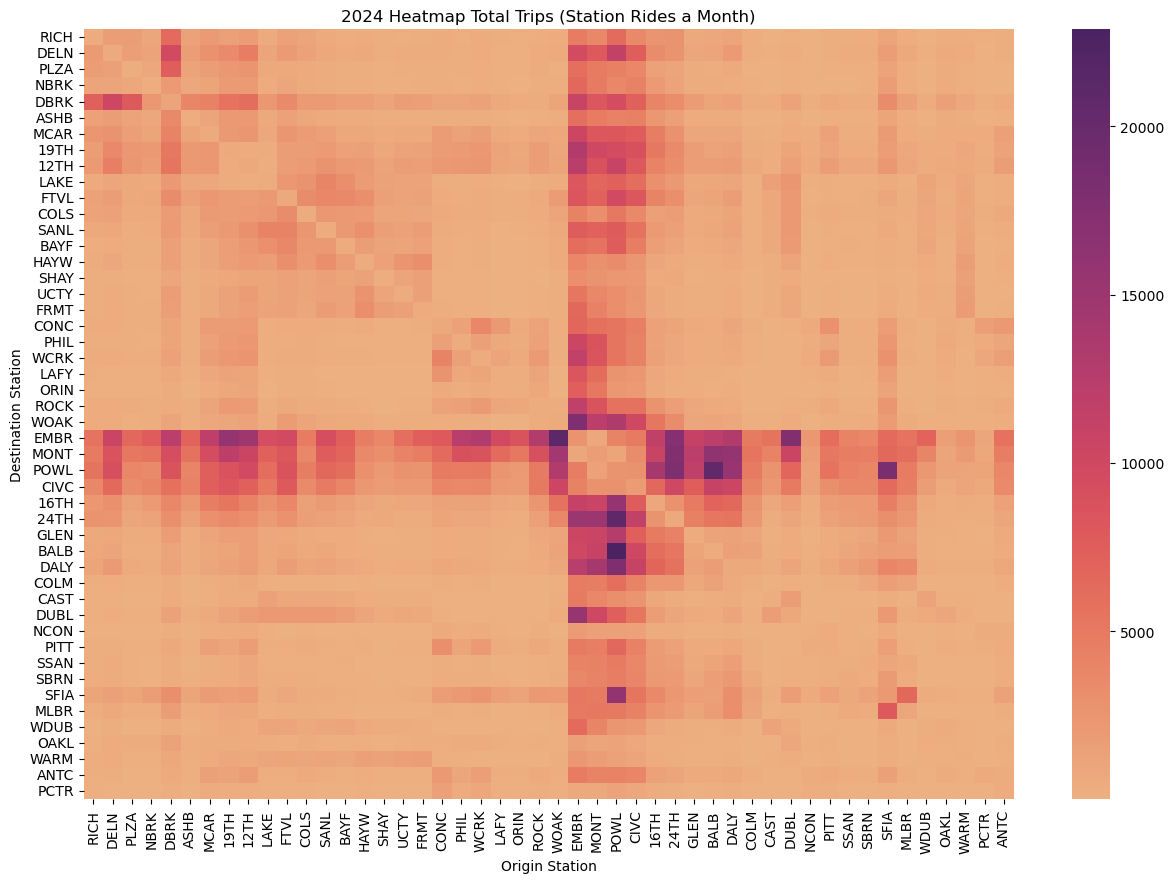

In [19]:
plt.figure(figsize=(15,10))
heatmap_2024 = sns.heatmap(pivot_month_23.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),cmap="flare")
plt.title("2024 Heatmap Total Trips (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")
plt.savefig("images/2023_heatmapALL.svg")
plt.savefig("images/2023_heatmapALL.png")

In [20]:
plt.figure
heatmap_2019 = sns.heatmap(pivot_23_JanFebMarApr.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),vmin=0, vmax=80000)
plt.title("2024 Jan-Apr Heatmap (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")

# plt.savefig("images/2019_heatmap.svg")
# plt.savefig("images/2019_heatmap.png")

NameError: name 'pivot_23_JanFebMarApr' is not defined

In [ ]:
plt.figure
pivot_23_MayJun = sns.heatmap(pivot_23_MayJun.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),vmin=0, vmax=80000)
plt.title("2023 May-Jun Heatmap (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")

# plt.savefig("images/2019_heatmap.svg")
# plt.savefig("images/2019_heatmap.png")

In [ ]:
plt.figure
pivot_23_JulAugSep = sns.heatmap(pivot_23_JulAugSep.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),vmin=0, vmax=80000)
plt.title("2023 Jul-Sep Heatmap (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")

# plt.savefig("images/2019_heatmap.svg")
# plt.savefig("images/2019_heatmap.png")

In [ ]:
plt.figure
pivot_23_OctNovDec = sns.heatmap(pivot_23_OctNovDec.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),vmin=0, vmax=80000)
plt.title("2023 Oct-Dec Heatmap (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")


# plt.savefig("images/2019_heatmap.svg")
# plt.savefig("images/2019_heatmap.png")

In [ ]:
#Import 2019
df2019 = pd.read_csv('date-hour-soo-dest-2019.csv', header = 0)
df2019 = df2019.groupby(['Date','Origin Station','Destination Station'])['Trip Count'].sum().reset_index()
df2019['Date'] = pd.to_datetime(df2019['Date'], format = '%Y-%m-%d')
df2019['Month'] = df2019['Date'].dt.month
to_pivot = df2019.groupby(['Month','Origin Station','Destination Station'])['Trip Count'].sum().reset_index().groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index()
to_pivot = to_pivot.pivot(index='Destination Station', columns='Origin Station', values='Trip Count')
to_pivot = to_pivot[df202312.columns.to_list()]
to_pivot = to_pivot.reindex(df202312.index.to_list())
#to_pivot.head(2)

## Map Plots

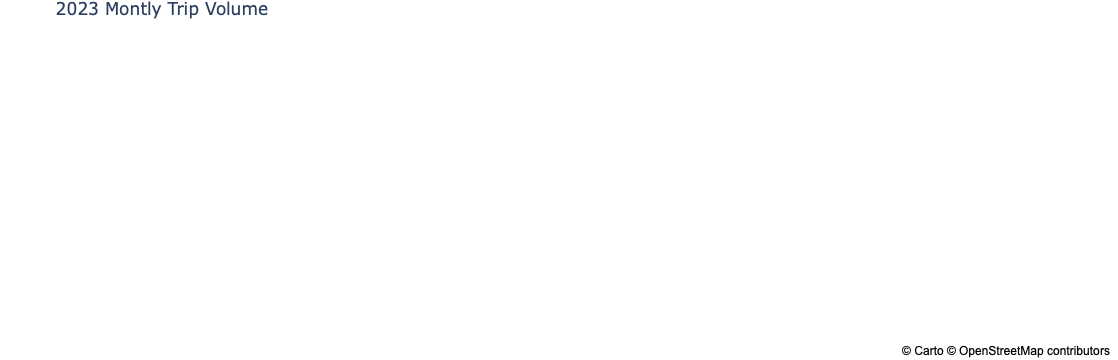

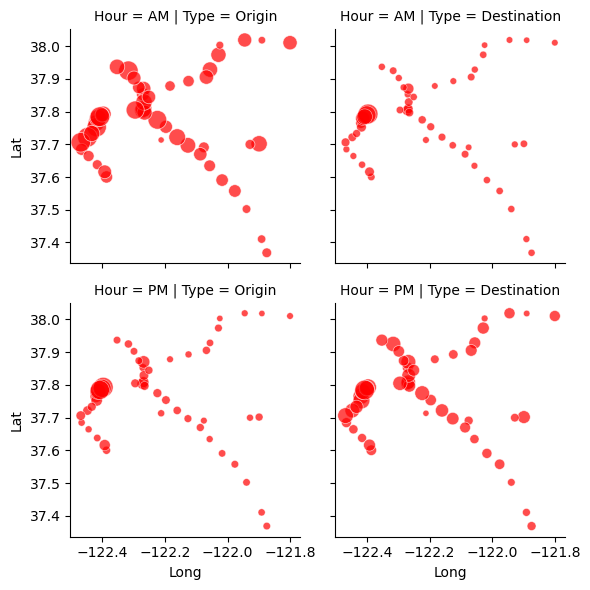

In [27]:
#2023 Import

df2023hr = pd.read_csv('date-hour-soo-dest-2023.csv', header = 0)
df2023hr['Hour'] = df2023hr['Hour'].apply(lambda x: 'AM' if x <13 else 'PM')
df2023hr = df2023hr.groupby(['Date','Origin Station','Destination Station','Hour'])['Trip Count'].sum().reset_index()
df2023hr.head(2)

SF_stations = ['EMBR','MONT','POWL','CIVC','16TH','24TH','GLEN','BALB','DALY','COLM','SSAN','SBRN','SFIA','MLBR']

def SF(x):
    '''
    Simple function to seprate stations in SF = 1, and Not in SF = 0
    '''
    if x in SF_stations:
        return 1
    else:
        return 0

df2023hr['Origin_SF'] = df2023hr['Origin Station'].apply(SF)
df2023hr['Destination_SF'] = df2023hr['Destination Station'].apply(SF)
df2023hr['Transbay'] = df2023hr['Origin_SF'] + df2023hr['Destination_SF']
df2023hr['Date'] = pd.to_datetime(df2023hr['Date'], format = '%Y-%m-%d')
df2023hr['Month'] = df2023hr['Date'].dt.month
df2023hr['Day'] = df2023hr['Date'].dt.dayofweek
df2023hr.head()

df2023_trips = df2023hr.copy()

df2023hr = df2023hr.groupby(['Month','Origin Station','Destination Station','Hour'])['Trip Count'].sum().reset_index()
df2023hr['Type'] = 'Origin'
df2023hr['Type2'] = 'Destination'
df2023hr = df2023hr[['Month','Type','Origin Station','Type2','Destination Station','Hour','Trip Count']]
df2023_pivot = pd.concat([
df2023hr[['Month','Type','Origin Station','Hour','Trip Count']].rename(
    columns = ({'Origin Station':'Station'})),
df2023hr[['Month','Type2','Destination Station','Hour','Trip Count']].rename(
    columns = ({'Type2':'Type','Destination Station':'Station'}))])
df2023_pivot
df2023_pivot_tot = df2023_pivot.merge(LL, how="left", left_on = "Station", right_on = "Station").groupby(
    ['Month','Station','Long','Lat'])['Trip Count'].sum().groupby(
    ['Station','Long','Lat']).mean().reset_index()

fig = px.scatter_mapbox(df2023_pivot_tot, 
                        lat='Lat', 
                        lon='Long', 
                        size='Trip Count', 
                        # color='size',
                        # color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=20, 
                        zoom=9,
                        mapbox_style="carto-positron",
                       hover_data=["Station"])

# Update layout for better appearance
fig.update_layout(title='2023 Montly Trip Volume',
                  margin={"r":5,"t":30,"l":0,"b":0})

# Show plot
fig.show()
# fig.write_image("images/2019Tripmap.png")
# fig.write_image("images/2019Tripmap.svg")

#Final
col_order = ['Origin', 'Destination']
g = sns.FacetGrid(df2023_pivot.groupby(['Month','Type','Station','Hour'])['Trip Count'].sum().reset_index().groupby(
    ['Type','Station','Hour'])['Trip Count'].mean().reset_index().merge(LL, how = 'left', on = 'Station'), 
                  col="Type", row="Hour", col_order = col_order)
g.map_dataframe(sns.scatterplot,"Long", "Lat", size = 'Trip Count', alpha=0.7,sizes=(20, 200), color = 'red')
g.savefig("images/2023_facet.svg")
g.savefig("images/2023_facet.png")

In [28]:
#2019 Import and groupby AM/PM #1
df2019hr = pd.read_csv('date-hour-soo-dest-2019.csv', header = 0)
df2019hr['Hour'] = df2019hr['Hour'].apply(lambda x: 'AM' if x <13 else 'PM')
df2019hr = df2019hr.groupby(['Date','Origin Station','Destination Station','Hour'])['Trip Count'].sum().reset_index()
df2019hr.head(2)

Date Origin Station Destination Station Hour  Trip Count
0  2019-01-01           12TH                12TH   AM           8
1  2019-01-01           12TH                12TH   PM           7

In [29]:
# Add SF/East Bay #2
SF_stations = ['EMBR','MONT','POWL','CIVC','16TH','24TH','GLEN','BALB','DALY','COLM','SSAN','SBRN','SFIA','MLBR']

def SF(x):
    '''
    Simple function to seprate stations in SF = 1, and Not in SF = 0
    '''
    if x in SF_stations:
        return 1
    else:
        return 0

df2019hr['Origin_SF'] = df2019hr['Origin Station'].apply(SF)
df2019hr['Destination_SF'] = df2019hr['Destination Station'].apply(SF)
df2019hr['Transbay'] = df2019hr['Origin_SF'] + df2019hr['Destination_SF']
df2019hr['Date'] = pd.to_datetime(df2019hr['Date'], format = '%Y-%m-%d')
df2019hr['Month'] = df2019hr['Date'].dt.month
df2019hr['Day'] = df2019hr['Date'].dt.dayofweek
df2019hr.head()

Date Origin Station Destination Station Hour  Trip Count  Origin_SF  \
0 2019-01-01           12TH                12TH   AM           8          0   
1 2019-01-01           12TH                12TH   PM           7          0   
2 2019-01-01           12TH                16TH   AM          31          0   
3 2019-01-01           12TH                16TH   PM          32          0   
4 2019-01-01           12TH                19TH   PM           1          0   

   Destination_SF  Transbay  Month  Day  
0               0         0      1    1  
1               0         0      1    1  
2               1         1      1    1  
3               1         1      1    1  
4               0         0      1    1

In [30]:
# Make a COPY - df2019_trips for TRIP WORK #3
df2019_trips = df2019hr.copy()
df2019_trips

Date Origin Station Destination Station Hour  Trip Count  \
0       2019-01-01           12TH                12TH   AM           8   
1       2019-01-01           12TH                12TH   PM           7   
2       2019-01-01           12TH                16TH   AM          31   
3       2019-01-01           12TH                16TH   PM          32   
4       2019-01-01           12TH                19TH   PM           1   
...            ...            ...                 ...  ...         ...   
1602619 2019-12-31           WOAK                WCRK   AM           8   
1602620 2019-12-31           WOAK                WCRK   PM           3   
1602621 2019-12-31           WOAK                WDUB   AM           3   
1602622 2019-12-31           WOAK                WOAK   AM           8   
1602623 2019-12-31           WOAK                WOAK   PM           7   

         Origin_SF  Destination_SF  Transbay  Month  Day  
0                0               0         0      1    1  
1                0               0         0      1    1  
2                0               1         1      1    1  
3                0               1         1      1    1  
4                0               0         0      1    1  
...            ...             ...       ...    ...  ...  
1602619          0               0         0     12    1  
1602620          0               0         0     12    1  
1602621          0               0         0     12    1  
1602622          0               0         0     12    1  
1602623          0               0         0     12    1  

[1602624 rows x 10 columns]

In [31]:
#Manually pivot - Can probably revisit and shorten #4

df2019hr = df2019hr.groupby(['Month','Origin Station','Destination Station','Hour'])['Trip Count'].sum().reset_index()
df2019hr['Type'] = 'Origin'
df2019hr['Type2'] = 'Destination'
df2019hr = df2019hr[['Month','Type','Origin Station','Type2','Destination Station','Hour','Trip Count']]
df2019_pivot = pd.concat([
df2019hr[['Month','Type','Origin Station','Hour','Trip Count']].rename(
    columns = ({'Origin Station':'Station'})),
df2019hr[['Month','Type2','Destination Station','Hour','Trip Count']].rename(
    columns = ({'Type2':'Type','Destination Station':'Station'}))])
df2019_pivot

Month         Type Station Hour  Trip Count
0          1       Origin    12TH   AM         419
1          1       Origin    12TH   PM         680
2          1       Origin    12TH   AM        3026
3          1       Origin    12TH   PM        4860
4          1       Origin    12TH   AM         723
...      ...          ...     ...  ...         ...
55393     12  Destination    WCRK   PM         204
55394     12  Destination    WDUB   AM          78
55395     12  Destination    WDUB   PM         140
55396     12  Destination    WOAK   AM         398
55397     12  Destination    WOAK   PM         482

[110796 rows x 5 columns]

In [32]:
# Prep df: Total Trips #5
df2019_pivot_tot = df2019_pivot.merge(LL, how="left", left_on = "Station", right_on = "Station").groupby(['Month','Station','Long','Lat'])['Trip Count'].sum().groupby(
    ['Station','Long','Lat']).mean().reset_index()

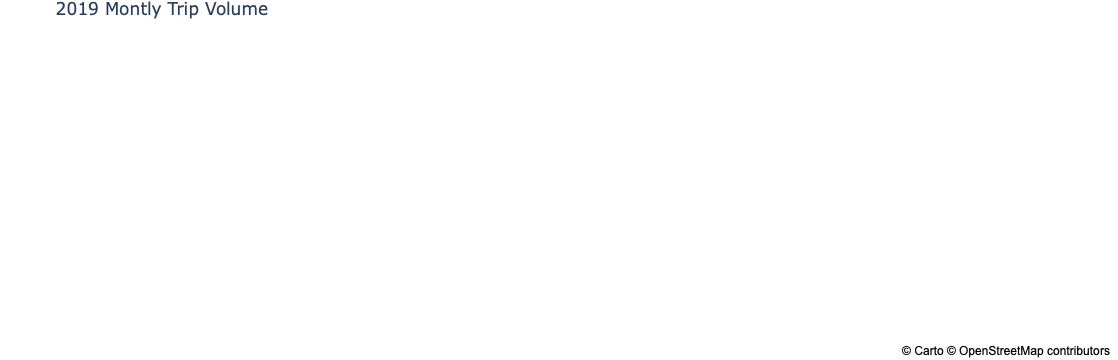

In [33]:
# Plot: Total Trips #6

fig = px.scatter_mapbox(df2019_pivot_tot, 
                        lat='Lat', 
                        lon='Long', 
                        size='Trip Count', 
                        # color='size',
                        # color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=20, 
                        zoom=9,
                        mapbox_style="carto-positron",
                       hover_data=["Station"])

# Update layout for better appearance
fig.update_layout(title='2019 Montly Trip Volume',
                  margin={"r":5,"t":30,"l":0,"b":0})

# Show plot
fig.show()
fig.write_image("images/2019Tripmap.png")
fig.write_image("images/2019Tripmap.svg")

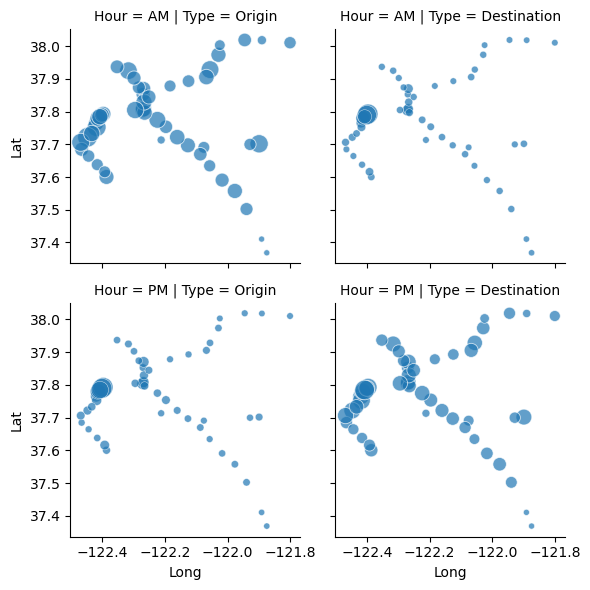

In [34]:
# Plot: 2019 Facet #7
col_order = ['Origin', 'Destination']
g = sns.FacetGrid(df2019_pivot.groupby(['Month','Type','Station','Hour'])['Trip Count'].sum().reset_index().groupby(
    ['Type','Station','Hour'])['Trip Count'].mean().reset_index().merge(LL, how = 'left', on = 'Station'), 
                  col="Type", row="Hour", col_order = col_order)
g.map_dataframe(sns.scatterplot,"Long", "Lat", size = 'Trip Count', alpha=0.7,sizes=(20, 200))
g.savefig("images/2019_facet.svg")
g.savefig("images/2019_facet.png")

In [35]:
# Avg monthly volume: Providing context into the facet marker scale. Each is normalized to its sample. 
# Sample is relative to avg monthly volumes. 

print('avg monthly volume 2019 ' + str(df2019_pivot.groupby(['Month'])['Trip Count'].sum().reset_index()['Trip Count'].mean()/2))
print('avg monthly volume 2013 ' + str(df2023_pivot.groupby(['Month'])['Trip Count'].sum().reset_index()['Trip Count'].mean()/2))

avg monthly volume 2019 9884133.75
avg monthly volume 2013 3090323.6


## Heat Maps

In [36]:
#2023

df2023ht = pd.read_csv('date-hour-soo-dest-2023.csv', header = 0)
df2023ht['Hour'] = df2023ht['Hour'].apply(lambda x: 'AM' if x <13 else 'PM')
# df2019ht = df2019hr.groupby(['Date','Origin Station','Destination Station','Hour'])['Trip Count'].sum().reset_index()
df2023ht.head(2)

Date Hour Origin Station Destination Station  Trip Count
0  2023-01-01   AM           12TH                12TH           1
1  2023-01-01   AM           12TH                16TH           1

In [37]:
#2019

df2019ht = pd.read_csv('date-hour-soo-dest-2019.csv', header = 0)
df2019ht['Hour'] = df2019ht['Hour'].apply(lambda x: 'AM' if x <13 else 'PM')
# df2019ht = df2019hr.groupby(['Date','Origin Station','Destination Station','Hour'])['Trip Count'].sum().reset_index()
df2019ht.head(2)

Date Hour Origin Station Destination Station  Trip Count
0  2019-01-01   AM           12TH                12TH           3
1  2019-01-01   AM           12TH                16TH           4

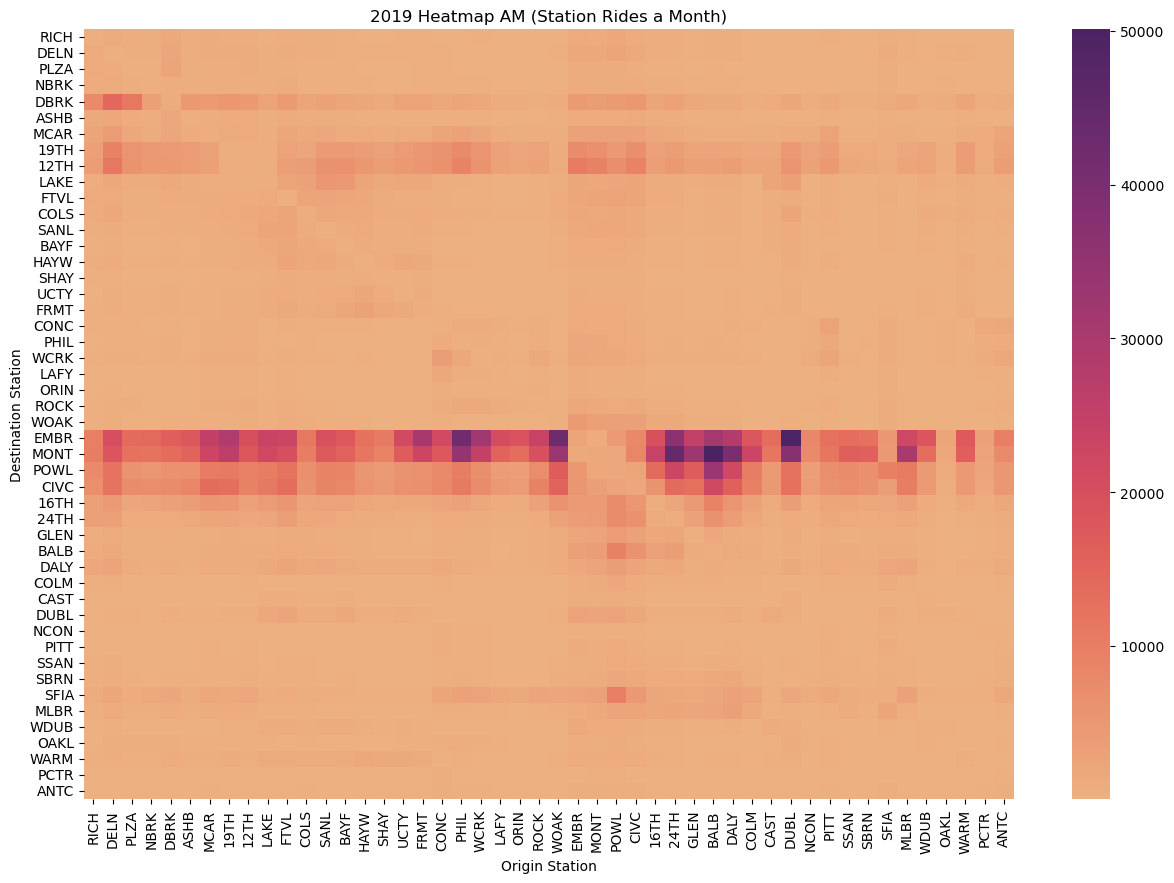

In [38]:
#2019 AM Heatmap
df2019AM = df2019ht[df2019ht['Hour'] == 'AM'].groupby(['Date','Origin Station','Destination Station'])['Trip Count'].sum().reset_index()
df2019AM['Date'] = pd.to_datetime(df2019AM['Date'], format = '%Y-%m-%d')
df2019AM['Month'] = df2019AM['Date'].dt.month
df2019AM = df2019AM.groupby(['Month','Origin Station','Destination Station'])['Trip Count'].sum().reset_index().groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index()
df2019AM = df2019AM.pivot(index='Destination Station', columns='Origin Station', values='Trip Count')
df2019AM = df2019AM[df202312.columns.to_list()]
df2019AM = df2019AM.reindex(df202312.index.to_list())
df2019AM.head(2)
plt.figure(figsize=(15,10))
heatmap_2019AM = sns.heatmap(df2019AM.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),cmap="flare")
plt.title("2019 Heatmap AM (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")
plt.savefig("images/2019_heatmapAM.svg")
plt.savefig("images/2019_heatmapAM.png")

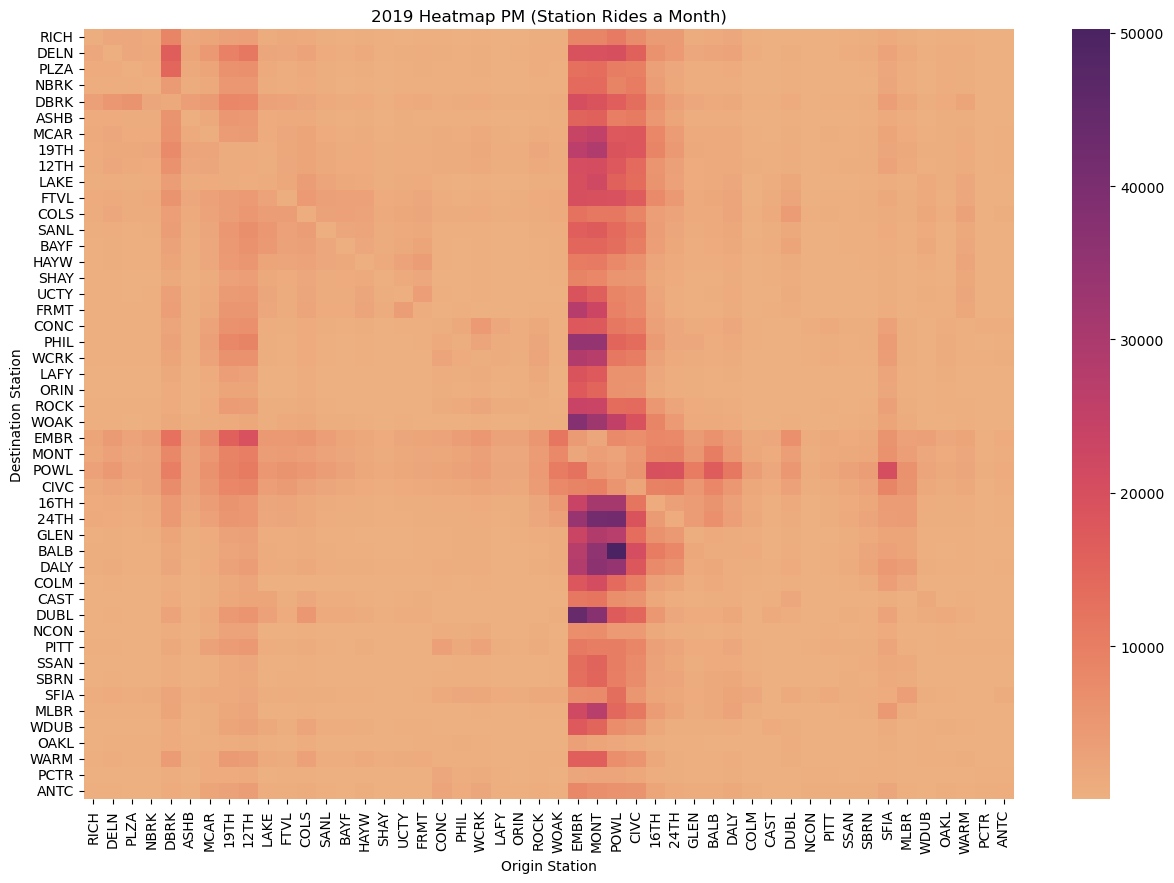

In [39]:
#2019 PM Heatmap
df2019AM = df2019ht[df2019ht['Hour'] == 'PM'].groupby(['Date','Origin Station','Destination Station'])['Trip Count'].sum().reset_index()
df2019AM['Date'] = pd.to_datetime(df2019AM['Date'], format = '%Y-%m-%d')
df2019AM['Month'] = df2019AM['Date'].dt.month
df2019AM = df2019AM.groupby(['Month','Origin Station','Destination Station'])['Trip Count'].sum().reset_index().groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index()
df2019AM = df2019AM.pivot(index='Destination Station', columns='Origin Station', values='Trip Count')
df2019AM = df2019AM[df202312.columns.to_list()]
df2019AM = df2019AM.reindex(df202312.index.to_list())
df2019AM.head(2)
plt.figure(figsize=(15,10))
heatmap_2019AM = sns.heatmap(df2019AM.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),cmap="flare")
plt.title("2019 Heatmap PM (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")
plt.savefig("images/2019_heatmapPM.svg")
plt.savefig("images/2019_heatmapPM.png")

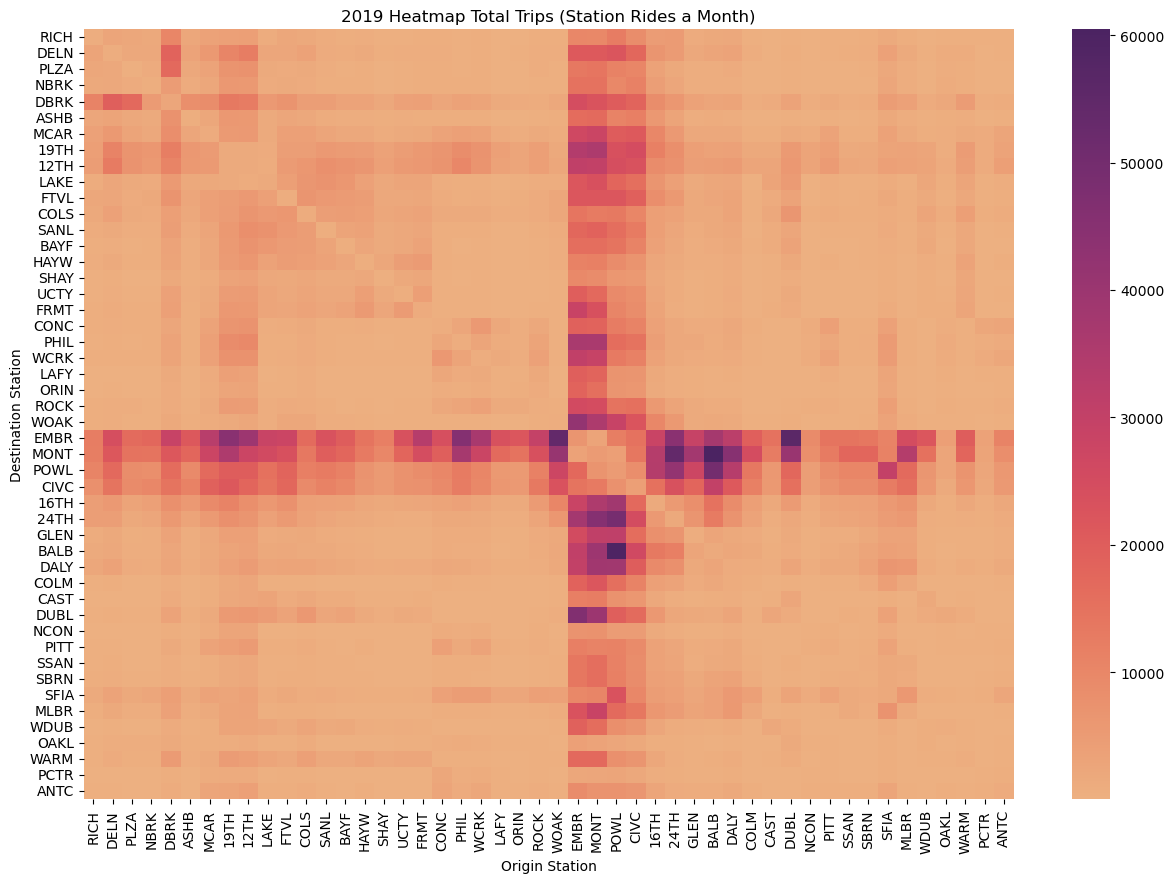

In [40]:
#2019 ALL DAY Heatmap
df2019ALL = df2019ht.groupby(['Date','Origin Station','Destination Station'])['Trip Count'].sum().reset_index()
df2019ALL['Date'] = pd.to_datetime(df2019ALL['Date'], format = '%Y-%m-%d')
df2019ALL['Month'] = df2019ALL['Date'].dt.month
df2019DAY = df2019ALL.copy()
df2019ALL = df2019ALL.groupby(['Month','Origin Station','Destination Station'])['Trip Count'].sum().reset_index().groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index()
df2019ALL = df2019ALL.pivot(index='Destination Station', columns='Origin Station', values='Trip Count')
df2019ALL = df2019ALL[df202312.columns.to_list()]
df2019ALL = df2019ALL.reindex(df202312.index.to_list())
df2019ALL.head(2)
plt.figure(figsize=(15,10))
heatmap_2019AM = sns.heatmap(df2019ALL.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),cmap="flare")
plt.title("2019 Heatmap Total Trips (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")
plt.savefig("images/2019_heatmapALL.svg")
plt.savefig("images/2019_heatmapALL.png")

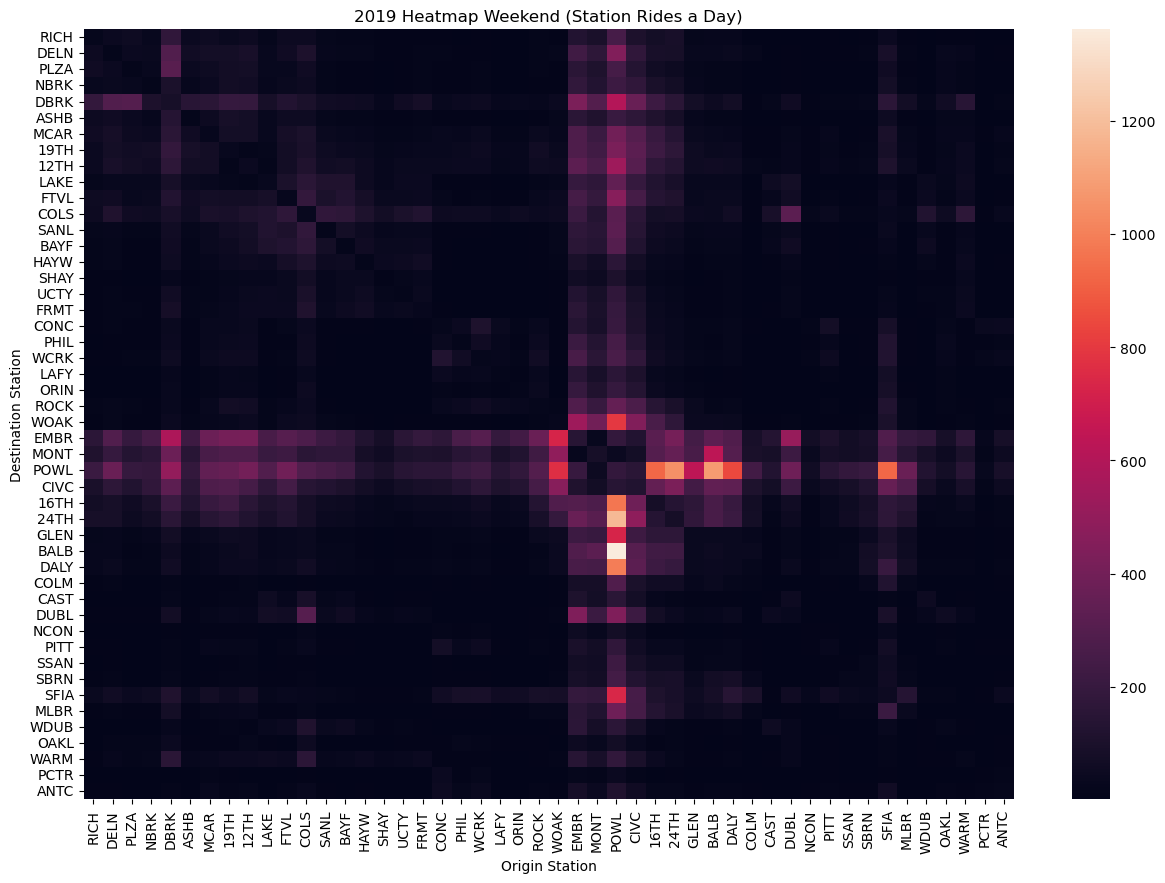

In [41]:
#2019 Weekend
df2019DAY['Day'] = df2019DAY['Date'].dt.dayofweek
df2019END = df2019DAY[df2019DAY.Day > 4].groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index().pivot(
    index='Destination Station', columns='Origin Station', values='Trip Count')
df2019END = df2019END[df202312.columns.to_list()]
df2019END = df2019END.reindex(df202312.index.to_list())
plt.figure(figsize=(15,10))
heatmap_2019END = sns.heatmap(df2019END.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],))
# cmap="flare"
plt.title("2019 Heatmap Weekend (Station Rides a Day)")
plt.savefig("images/2019_heatmapEND.svg")
plt.savefig("images/2019_heatmapEND.png")

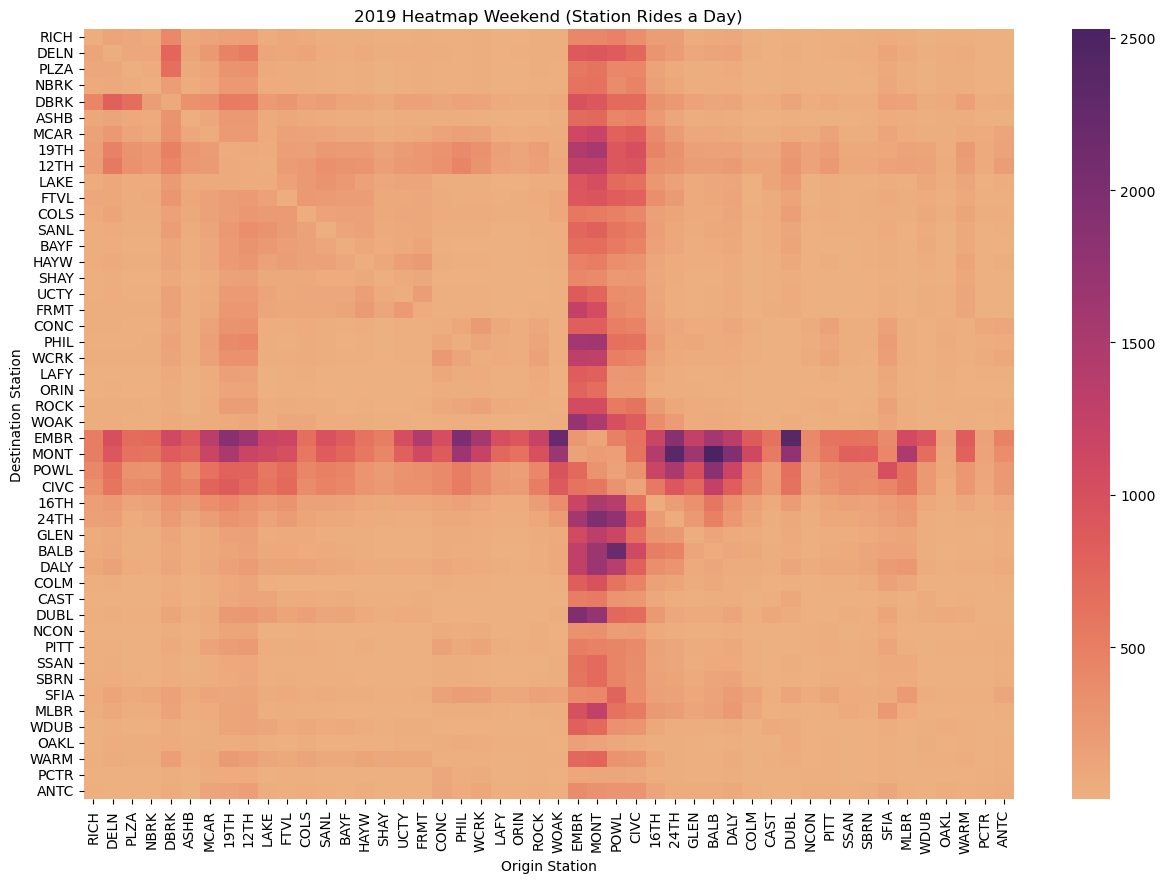

In [42]:
#2019 Weekday
df2019DAY['Day'] = df2019DAY['Date'].dt.dayofweek
df2019WK = df2019DAY[df2019DAY.Day < 5].groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index().pivot(
    index='Destination Station', columns='Origin Station', values='Trip Count')
df2019WK = df2019WK[df202312.columns.to_list()]
df2019WK = df2019WK.reindex(df202312.index.to_list())
plt.figure(figsize=(15,10))
heatmap_2019WK = sns.heatmap(df2019WK.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],),cmap="flare")
plt.title("2019 Heatmap Weekend (Station Rides a Day)")
plt.savefig("images/2019_heatmapWK.svg")
plt.savefig("images/2019_heatmapWK.png")

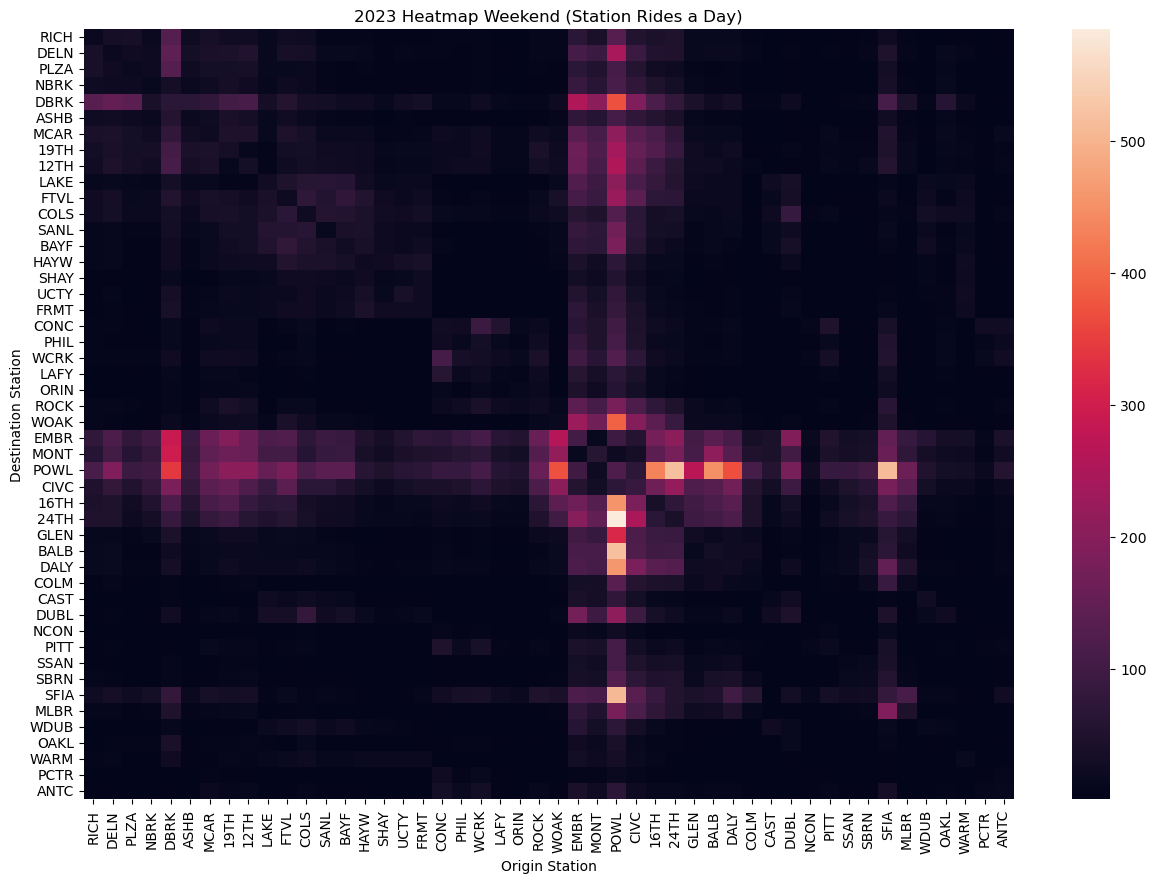

In [43]:
#2023 Heatmaps for weekend/weekday split

df2023ALL = df2023ht.groupby(['Date','Origin Station','Destination Station'])['Trip Count'].sum().reset_index()
df2023ALL['Date'] = pd.to_datetime(df2023ALL['Date'], format = '%Y-%m-%d')
df2023ALL['Month'] = df2023ALL['Date'].dt.month
df2023DAY = df2023ALL.copy()

df2023DAY['Day'] = df2023DAY['Date'].dt.dayofweek
df2023END = df2023DAY[df2023DAY.Day > 4].groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index().pivot(
    index='Destination Station', columns='Origin Station', values='Trip Count')
df2023END = df2023END[df202312.columns.to_list()]
df2023END = df2023END.reindex(df202312.index.to_list())
plt.figure(figsize=(15,10))
heatmap_2023END = sns.heatmap(df2023END.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],))
# cmap="flare"
plt.title("2023 Heatmap Weekend (Station Rides a Day)")
plt.savefig("images/2019_heatmapWK.svg")
plt.savefig("images/2019_heatmapWK.png")

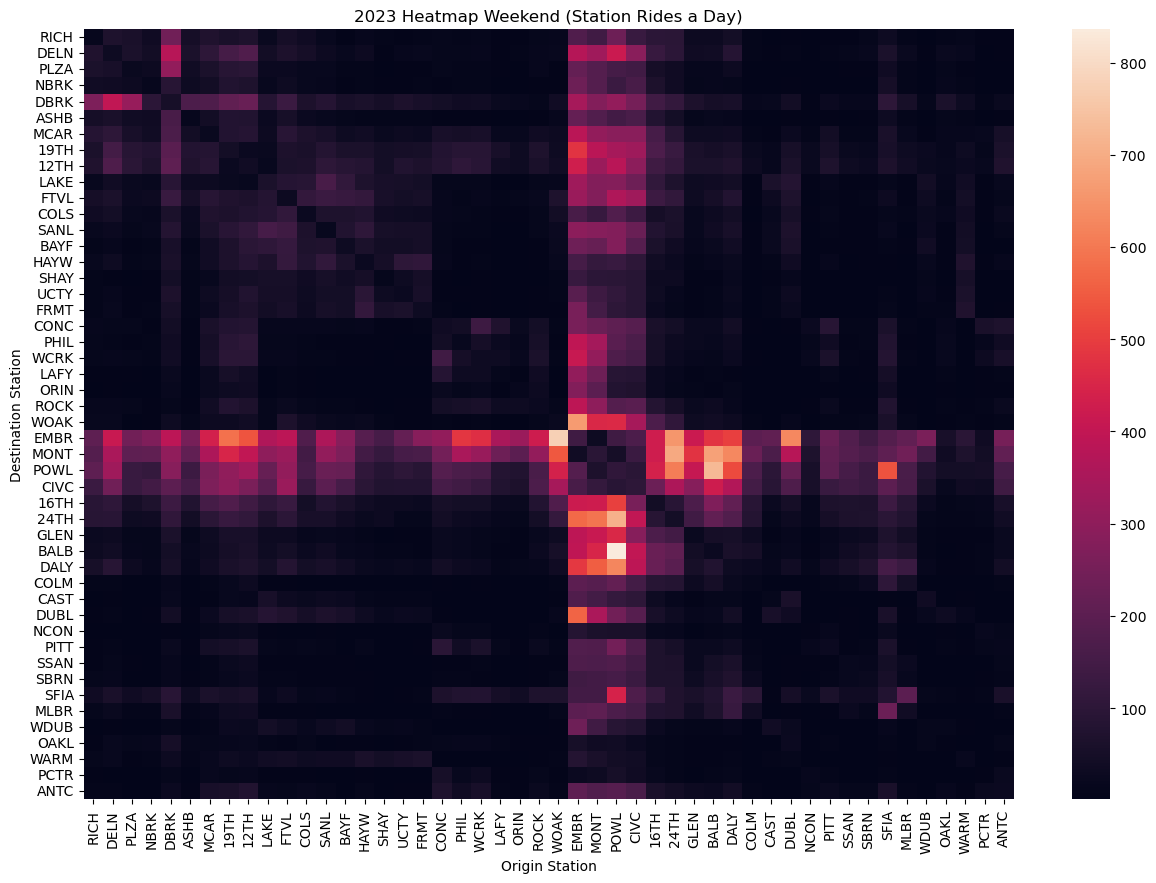

In [44]:
#2023 Weekday

df2023DAY['Day'] = df2023DAY['Date'].dt.dayofweek
df2023END = df2023DAY[df2023DAY.Day < 5].groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index().pivot(
    index='Destination Station', columns='Origin Station', values='Trip Count')
df2023END = df2023END[df202312.columns.to_list()]
df2023END = df2023END.reindex(df202312.index.to_list())
plt.figure(figsize=(15,10))
heatmap_2023END = sns.heatmap(df2023END.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],))
# cmap="flare"
plt.title("2023 Heatmap Weekend (Station Rides a Day)")
plt.savefig("images/2023_heatmapEND.svg")
plt.savefig("images/2023_heatmapEND.png")

#### Transbay

In [45]:
df2023_trips.head(2)

Date Origin Station Destination Station Hour  Trip Count  Origin_SF  \
0 2023-01-01           12TH                12TH   AM          32          0   
1 2023-01-01           12TH                12TH   PM          10          0   

   Destination_SF  Transbay  Month  Day  
0               0         0      1    6  
1               0         0      1    6

In [46]:
df2023_trans = df2023_trips.groupby(['Date','Transbay','Month','Day'])['Trip Count'].sum().reset_index()
df2023_trans['Day Type'] = df2023_trans.Day.apply(lambda x: 'weekend' if x > 4 else 'weekday')
df2023_trans = df2023_trans.groupby(['Day Type','Transbay'])['Trip Count'].mean().reset_index()
df2023_trans

Day Type  Transbay    Trip Count
0  weekday         0  35842.413793
1  weekday         1  77070.034483
2  weekday         2  36188.287356
3  weekend         0  17239.971429
4  weekend         1  34848.971429
5  weekend         2  18764.028571

Day Type        Transbay    Trip Count  Trip Count Day Tot  \
0  weekday  Intra East Bay  35842.413793       149100.735632   
1  weekday        Transbay  77070.034483       149100.735632   
2  weekday        Intra SF  36188.287356       149100.735632   
3  weekend  Intra East Bay  17239.971429        70852.971429   
4  weekend        Transbay  34848.971429        70852.971429   
5  weekend        Intra SF  18764.028571        70852.971429   

   Trip Count Percent   Net ToT  Year  
0                0.24  0.162954  2023  
1                0.52  0.350392  2023  
2                0.24  0.164527  2023  
3                0.24  0.078380  2023  
4                0.49  0.158438  2023  
5                0.26  0.085309  2023

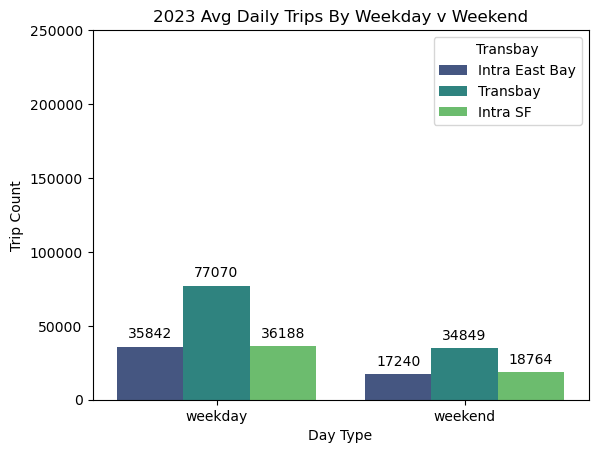

In [48]:
df2023_trans = df2023_trips.groupby(['Date','Transbay','Month','Day'])['Trip Count'].sum().reset_index()
df2023_trans['Day Type'] = df2023_trans.Day.apply(lambda x: 'weekend' if x > 4 else 'weekday')
df2023_trans = df2023_trans.groupby(['Day Type','Transbay'])['Trip Count'].mean().reset_index()
df2023_trans['Transbay'] = df2023_trans.Transbay.apply(lambda x: 'Intra East Bay' if x == 0 else ( 'Transbay' if x==1 else 'Intra SF'))
df2023_trans['Trip Count Day Tot'] = df2023_trans['Day Type'].apply(
    lambda x: df2023_trans[df2023_trans['Day Type']== 'weekday']
    ['Trip Count'].sum() if x == 'weekday' else df2023_trans[df2023_trans['Day Type']== 'weekend']['Trip Count'].sum())
df2023_trans['Trip Count Percent'] = (df2023_trans['Trip Count'] / df2023_trans['Trip Count Day Tot']).round(2)
df2023_trans['Net ToT'] = df2023_trans['Trip Count']/df2023_trans['Trip Count Day Tot'].value_counts().reset_index()\
['Trip Count Day Tot'].sum()
df2023_trans['Year'] = 2023
df2023_trans
obj = sns.barplot(df2023_trans, x="Day Type", y="Trip Count", hue="Transbay", palette = 'viridis')
plt.title('2023 Avg Daily Trips By Weekday v Weekend')
plt.ylim(0,250000)
for p in obj.patches:
    obj.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
plt.savefig("images/2023_transit_type.svg")
plt.savefig("images/2023_transit_type.png")
#percentage of volume
(df2023_trans['Trip Count Day Tot'].value_counts().reset_index()['Trip Count Day Tot']/\
df2023_trans['Trip Count Day Tot'].value_counts().reset_index()['Trip Count Day Tot'].sum()).round(2)
df2023_trans['Trip Count Day Tot'].value_counts().reset_index()['Trip Count Day Tot'].sum()
df2023_trans

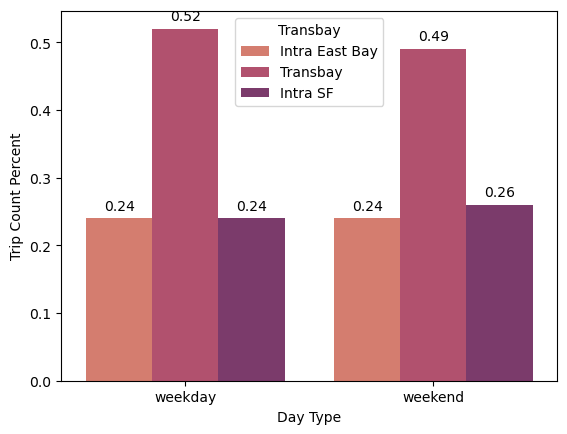

In [49]:
obj = sns.barplot(df2023_trans, x="Day Type", y="Trip Count Percent", hue="Transbay", palette = 'flare',)
# plt.title('2023 Avg Trip Percent By Weekday and Weekend')
for p in obj.patches:
    obj.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')

0    0.742109
1    0.257891
Name: Trip Count Day Tot, dtype: float64

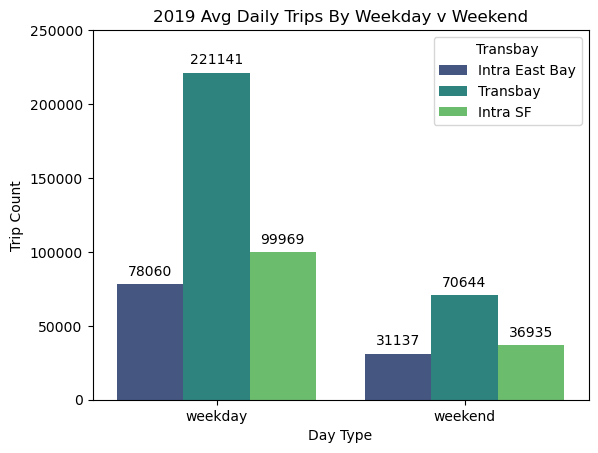

In [51]:
df2019_trans = df2019_trips.groupby(['Date','Transbay','Month','Day'])['Trip Count'].sum().reset_index()
df2019_trans['Day Type'] = df2019_trans.Day.apply(lambda x: 'weekend' if x > 4 else 'weekday')
df2019_trans = df2019_trans.groupby(['Day Type','Transbay'])['Trip Count'].mean().reset_index()
df2019_trans['Transbay'] = df2019_trans.Transbay.apply(lambda x: 'Intra East Bay' if x == 0 else ( 'Transbay' if x==1 else 'Intra SF'))
df2019_trans['Trip Count Day Tot'] = df2019_trans['Day Type'].apply(
    lambda x: df2019_trans[df2019_trans['Day Type']== 'weekday']['Trip Count']\
    .sum() if x == 'weekday' else df2019_trans[df2019_trans['Day Type']== 'weekend']['Trip Count'].sum())
df2019_trans['Trip Count Percent'] = (df2019_trans['Trip Count'] / df2019_trans['Trip Count Day Tot']).round(2)
df2019_trans['Year'] = 2019
df2019_trans
obj = sns.barplot(df2019_trans, x="Day Type", y="Trip Count", hue="Transbay", palette = 'viridis')
plt.title('2019 Avg Daily Trips By Weekday v Weekend')
plt.ylim(0,250000)
for p in obj.patches:
    obj.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
plt.savefig("images/2019_transit_type.svg")
plt.savefig("images/2019_transit_type.png")
df2019_trans['Trip Count Day Tot'].value_counts().reset_index()['Trip Count Day Tot']/\
df2019_trans['Trip Count Day Tot'].value_counts().reset_index()['Trip Count Day Tot'].sum()

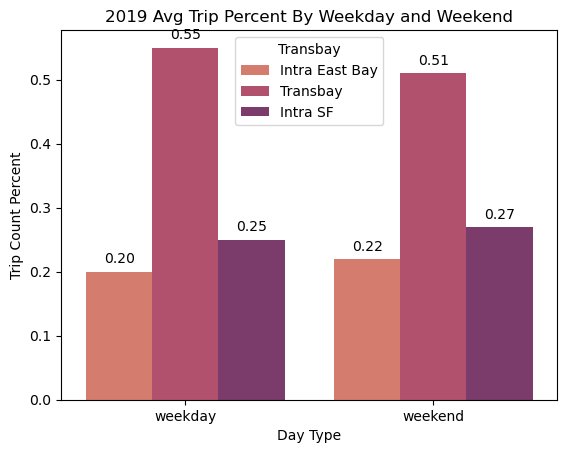

In [52]:
obj = sns.barplot(df2019_trans, x="Day Type", y="Trip Count Percent", hue="Transbay", palette = 'flare')
plt.title('2019 Avg Trip Percent By Weekday and Weekend')



for p in obj.patches:
    obj.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9),textcoords='offset points')

In [53]:
pd.concat([df2019_trans,df2023_trans])

Day Type        Transbay     Trip Count  Trip Count Day Tot  \
0  weekday  Intra East Bay   78059.712644       399169.321839   
1  weekday        Transbay  221140.689655       399169.321839   
2  weekday        Intra SF   99968.919540       399169.321839   
3  weekend  Intra East Bay   31136.798077       138715.500000   
4  weekend        Transbay   70643.605769       138715.500000   
5  weekend        Intra SF   36935.096154       138715.500000   
0  weekday  Intra East Bay   35842.413793       149100.735632   
1  weekday        Transbay   77070.034483       149100.735632   
2  weekday        Intra SF   36188.287356       149100.735632   
3  weekend  Intra East Bay   17239.971429        70852.971429   
4  weekend        Transbay   34848.971429        70852.971429   
5  weekend        Intra SF   18764.028571        70852.971429   

   Trip Count Percent  Year   Net ToT  
0                0.20  2019       NaN  
1                0.55  2019       NaN  
2                0.25  2019       NaN  
3                0.22  2019       NaN  
4                0.51  2019       NaN  
5                0.27  2019       NaN  
0                0.24  2023  0.162954  
1                0.52  2023  0.350392  
2                0.24  2023  0.164527  
3                0.24  2023  0.078380  
4                0.49  2023  0.158438  
5                0.26  2023  0.085309

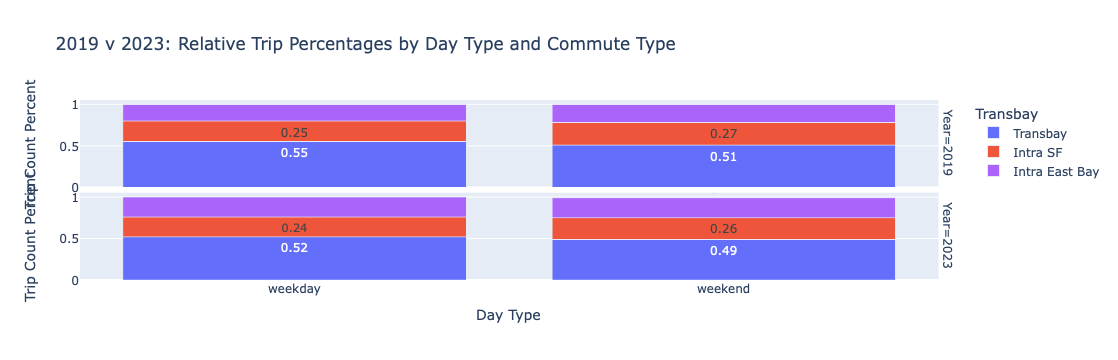

In [57]:
import plotly.express as px

normal = px.bar(pd.concat([df2019_trans,df2023_trans]), 
           x = "Day Type", y="Trip Count Percent", 
             color = 'Transbay', 
             facet_row="Year",
             title="2019 v 2023: Relative Trip Percentages by Day Type and Commute Type", 
             text_auto=True,
                barmode='relative',
            category_orders={"Transbay": ["Transbay", "Intra SF", "Instra East Bay"],})
# normal.update_yaxes(visible = False) 
normal.show()
normal.write_image("images/normal.png")
normal.write_image("images/normal.svg")

In [58]:
pd.concat([df2019_trans,df2023_trans])

Day Type        Transbay     Trip Count  Trip Count Day Tot  \
0  weekday  Intra East Bay   78059.712644       399169.321839   
1  weekday        Transbay  221140.689655       399169.321839   
2  weekday        Intra SF   99968.919540       399169.321839   
3  weekend  Intra East Bay   31136.798077       138715.500000   
4  weekend        Transbay   70643.605769       138715.500000   
5  weekend        Intra SF   36935.096154       138715.500000   
0  weekday  Intra East Bay   35842.413793       149100.735632   
1  weekday        Transbay   77070.034483       149100.735632   
2  weekday        Intra SF   36188.287356       149100.735632   
3  weekend  Intra East Bay   17239.971429        70852.971429   
4  weekend        Transbay   34848.971429        70852.971429   
5  weekend        Intra SF   18764.028571        70852.971429   

   Trip Count Percent  Year   Net ToT  
0                0.20  2019       NaN  
1                0.55  2019       NaN  
2                0.25  2019       NaN  
3                0.22  2019       NaN  
4                0.51  2019       NaN  
5                0.27  2019       NaN  
0                0.24  2023  0.162954  
1                0.52  2023  0.350392  
2                0.24  2023  0.164527  
3                0.24  2023  0.078380  
4                0.49  2023  0.158438  
5                0.26  2023  0.085309

#### Distance 

In [59]:
df2023route = df2023_trips.drop(columns = (['Origin_SF','Destination_SF']))
df2023route = df2023route.merge(
    LL, how = 'left', left_on = 'Origin Station', right_on = 'Station').merge(
    LL, how = 'left', left_on = 'Destination Station', right_on = 'Station')
df2023route['Day Type'] = df2023route.Day.apply(lambda x: 'weekend' if x > 4 else 'weekday')
df2023route['O Coor'] = list(zip(pd.Series(zip(df2023route['Lat_x'].to_list(), df2023route['Long_x'].to_list())),
                                 pd.Series(zip(df2023route['Lat_y'].to_list(), df2023route['Long_y'].to_list()))))

print(df2023route.shape)
df2023route.head(2)

(542041, 16)


Date Origin Station Destination Station Hour  Trip Count  Transbay  \
0 2023-01-01           12TH                12TH   AM          32         0   
1 2023-01-01           12TH                12TH   PM          10         0   

   Month  Day Station_x    Long_x    Lat_x Station_y    Long_y    Lat_y  \
0      1    6      12TH -122.2714  37.8037      12TH -122.2714  37.8037   
1      1    6      12TH -122.2714  37.8037      12TH -122.2714  37.8037   

  Day Type                                        O Coor  
0  weekend  ((37.8037, -122.2714), (37.8037, -122.2714))  
1  weekend  ((37.8037, -122.2714), (37.8037, -122.2714))

In [60]:
#Monthly
df2023route_c = df2023route.groupby(
    ['Month','Hour','Origin Station','Destination Station','O Coor'])['Trip Count'].sum().reset_index().groupby(
    ['Hour','Origin Station','Destination Station','O Coor'])['Trip Count'].mean().reset_index()
df2023route_c['Dist_miles'] = df2023route_c['O Coor'].apply(lambda x: geopy.distance.geodesic(x[0], x[1]).miles)
df2023route_c

Hour Origin Station Destination Station  \
0      AM           12TH                12TH   
1      AM           12TH                16TH   
2      AM           12TH                19TH   
3      AM           12TH                24TH   
4      AM           12TH                ANTC   
...   ...            ...                 ...   
4995   PM           WOAK                UCTY   
4996   PM           WOAK                WARM   
4997   PM           WOAK                WCRK   
4998   PM           WOAK                WDUB   
4999   PM           WOAK                WOAK   

                                             O Coor  Trip Count  Dist_miles  
0      ((37.8037, -122.2714), (37.8037, -122.2714))       366.6    0.000000  
1       ((37.8037, -122.2714), (37.765, -122.4196))      1224.2    8.539687  
2      ((37.8037, -122.2714), (37.8083, -122.2686))       206.2    0.352312  
3      ((37.8037, -122.2714), (37.7524, -122.4181))       733.4    8.775293  
4     ((37.8037, -122.2714), (38.01052, -121.8003))       119.0   29.431038  
...                                             ...         ...         ...  
4995   ((37.8048, -122.2951), (37.5906, -122.0173))        74.6   21.212755  
4996   ((37.8048, -122.2951), (37.5021, -121.9393))       122.4   28.573053  
4997   ((37.8048, -122.2951), (37.9055, -122.0675))        72.2   14.252639  
4998   ((37.8048, -122.2951), (37.6997, -121.9282))        73.0   21.358843  
4999   ((37.8048, -122.2951), (37.8048, -122.2951))       300.0    0.000000  

[5000 rows x 6 columns]

In [61]:
#Monthly Trip Distance Stats
df2023route_c['Trip Count'].sum()
df2023route_c[['Dist_miles']].describe()

Dist_miles
count  5000.000000
mean     17.495547
std      10.439980
min       0.000000
25%       9.548380
50%      16.223211
75%      24.642693
max      47.167417

Text(0.5, 1.0, 'Monthly Avg Trip Distances')

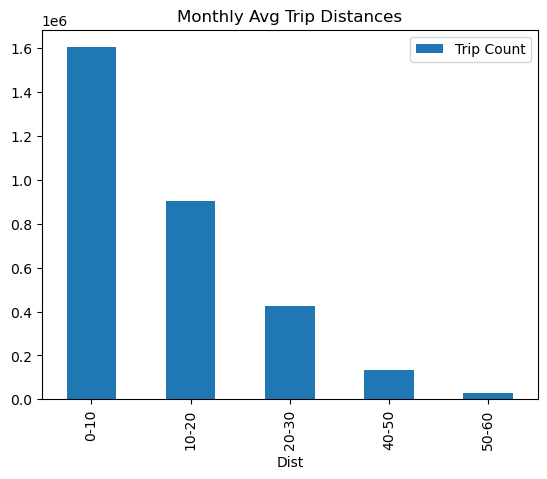

In [62]:
#Bucketing Monthly Trip Distance
df2023route_c['Dist'] = np.where(df2023route_c['Dist_miles']<10, '0-10',
                        np.where(df2023route_c['Dist_miles']<20, '10-20',
                        np.where(df2023route_c['Dist_miles']<30, '20-30',
                        np.where(df2023route_c['Dist_miles']<40, '40-50', '50-60'))))
df2023route_c.groupby('Dist')['Trip Count'].sum().reset_index().plot(kind = 'bar', x = 'Dist', y = 'Trip Count')
plt.title('Monthly Avg Trip Distances')
# df2023route_c   

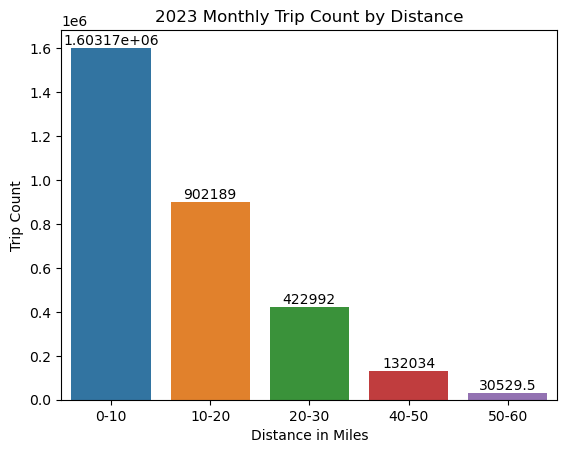

In [63]:
#All Stations Dist

plt.figure
ax = sns.barplot(df2023route_c.groupby('Dist')['Trip Count'].sum().reset_index(), x = 'Dist', y = 'Trip Count')
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('2023 Monthly Trip Count by Distance')
plt.xlabel('Distance in Miles')
plt.savefig("images/2023_trip_dist.svg")
plt.savefig("images/2023_trip_dist.png")

/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



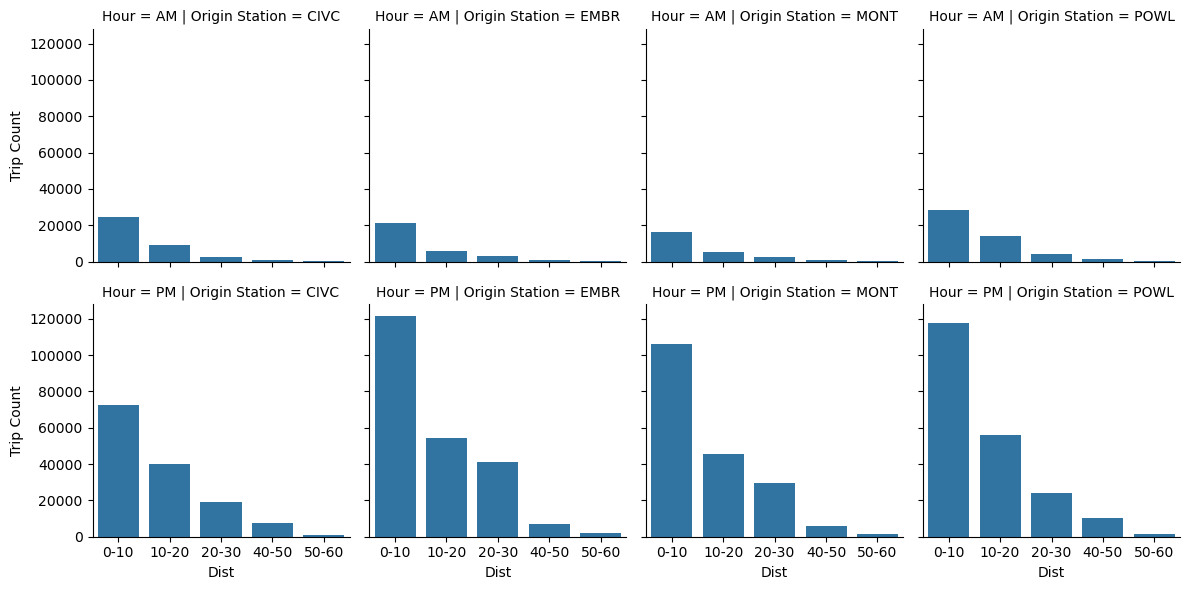

In [64]:
# Origin, Distance Travelled SF Downtown

SF_downton = ['EMBR','MONT','POWL','CIVC']
g = sns.FacetGrid(df2023route_c[df2023route_c['Origin Station'].isin(SF_downton)].groupby(
    ['Origin Station','Hour','Dist'])['Trip Count'].sum().reset_index(), row='Hour', col = 'Origin Station')
g.map(sns.barplot, "Dist", "Trip Count")
plt.savefig("images/2023_dt_breakdown.svg")
plt.savefig("images/2023_dt_breakdown.png")

/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



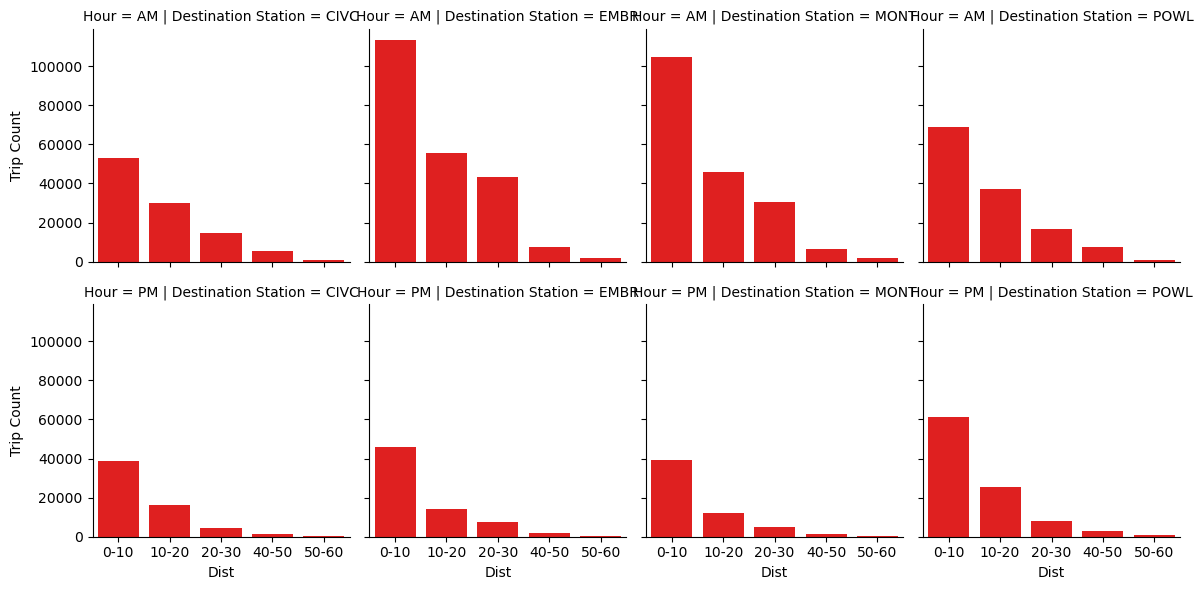

In [65]:
SF_downton = ['EMBR','MONT','POWL','CIVC']
g = sns.FacetGrid(df2023route_c[df2023route_c['Destination Station'].isin(SF_downton)].groupby(
    ['Destination Station','Hour','Dist'])['Trip Count'].sum().reset_index(), row='Hour', col = 'Destination Station')
g.map(sns.barplot, "Dist", "Trip Count", color='red')
plt.savefig("images/2019_dt_breakdown.svg")
plt.savefig("images/2019_dt_breakdown.png")

In [66]:
#Monthly Top Trips (Origin is SF Downtown)
top_routes = df2023route.groupby(
    ['Month','Origin Station','Destination Station','Transbay'])['Trip Count'].sum().reset_index(). groupby(
    ['Origin Station','Destination Station','Transbay'])['Trip Count'].mean().reset_index()
top_routes[top_routes['Origin Station'].isin(SF_downton)].sort_values(by='Trip Count', ascending = False).head(20)

print('Percent Intra SF total ' + str(top_routes[top_routes['Origin Station'].isin(SF_downton)].groupby(
    ['Transbay'])['Trip Count'].sum().loc[2]\
/top_routes[top_routes['Origin Station'].isin(SF_downton)].groupby(['Transbay'])['Trip Count'].sum().sum()))
top_routes[top_routes['Origin Station'].isin(SF_downton)].groupby(['Transbay'])['Trip Count'].sum()

Percent Intra SF total 0.34264044110102637


Transbay
1    597109.4
2    311235.8
Name: Trip Count, dtype: float64

In [83]:
#Top 20 Routes 
top_routes[top_routes['Origin Station'].isin(SF_downton)].sort_values(by='Trip Count', ascending = False).head(20)
top_routes[top_routes['Destination Station'].isin(SF_downton)].sort_values(by='Trip Count', ascending = False).head(20).groupby(
    ['Transbay'])['Trip Count'].sum()
top_routes[top_routes['Destination Station'].isin(SF_downton)].sort_values(by='Trip Count', ascending = False).groupby(
    ['Transbay'])['Trip Count'].sum()
#     .'plot(x='Destination Station',y=
#     king = 'bar', x = 
# )

Transbay
1    614360.0
2    318923.8
Name: Trip Count, dtype: float64

In [68]:
#Top 20 trips out of SF Downtown by Transbay
top_routes[top_routes['Origin Station'].isin(SF_downton)].sort_values(
    by='Trip Count', ascending = False).head(20).groupby(['Transbay'])['Trip Count'].sum().reset_index()

Transbay  Trip Count
0         1     71105.4
1         2    150331.6

In [69]:
#Top 20 trips into SF Downtown by Transbay
top_routes[top_routes['Destination Station'].isin(SF_downton)].sort_values(
    by='Trip Count', ascending = False).head(20).groupby(['Transbay'])['Trip Count'].sum().reset_index()

Transbay  Trip Count
0         1     80003.0
1         2    153365.8

Origin Station  Transbay
CIVC            1           115658.8
                2            62389.4
EMBR            1           185290.6
                2            72324.6
MONT            1           144718.6
                2            69270.4
POWL            1           151441.4
                2           107251.4
Name: Trip Count, dtype: float64

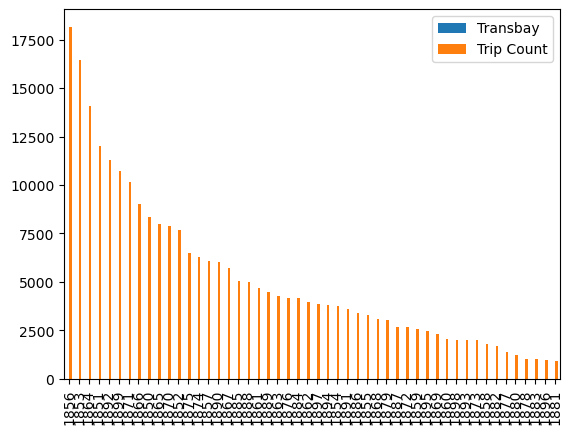

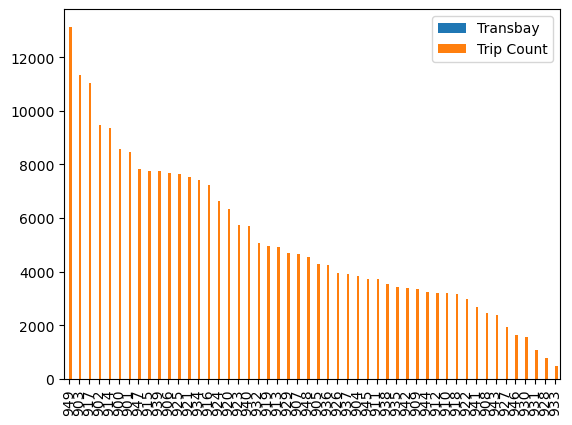

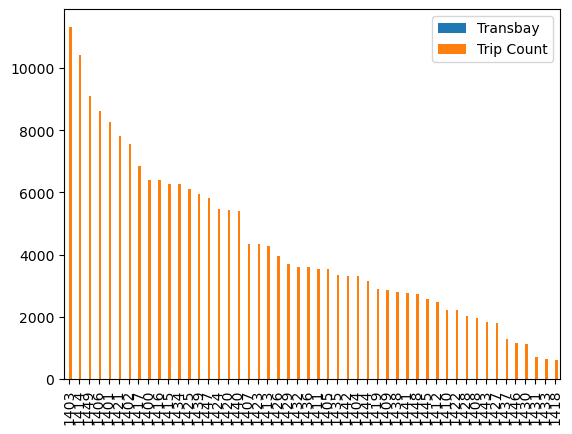

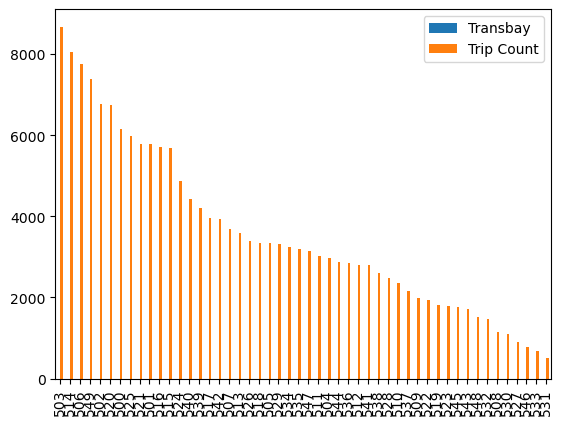

In [70]:
top_routes[top_routes['Origin Station']=='POWL'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Origin Station']=='EMBR'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Origin Station']=='MONT'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Origin Station']=='CIVC'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Origin Station']=='POWL'].sort_values(by='Trip Count', ascending = False)
top_routes[top_routes['Origin Station'].isin(SF_downton)].groupby(['Origin Station','Transbay'])['Trip Count'].sum()

<Axes: >

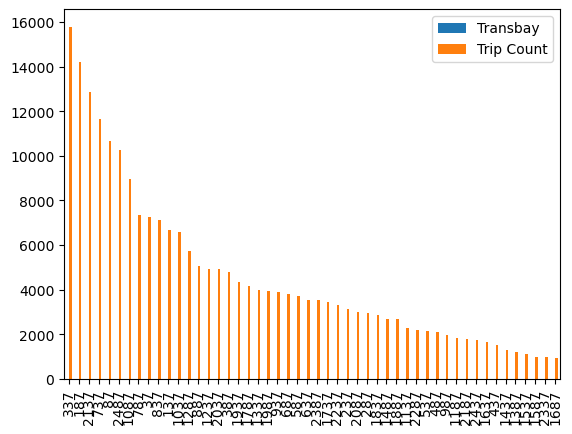

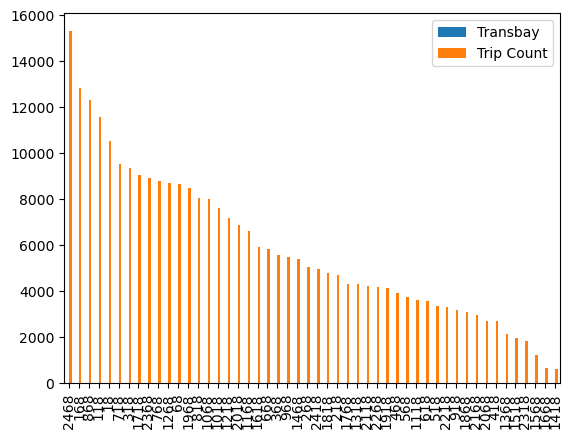

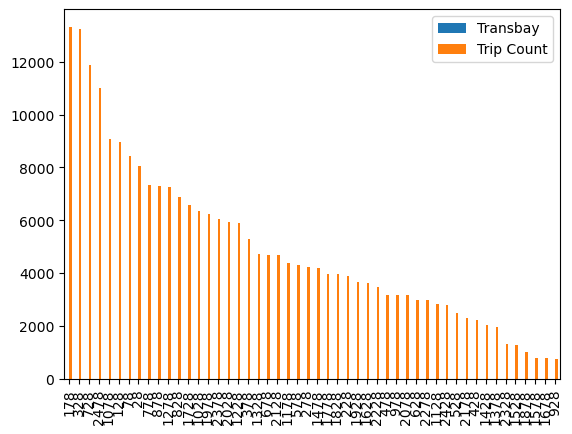

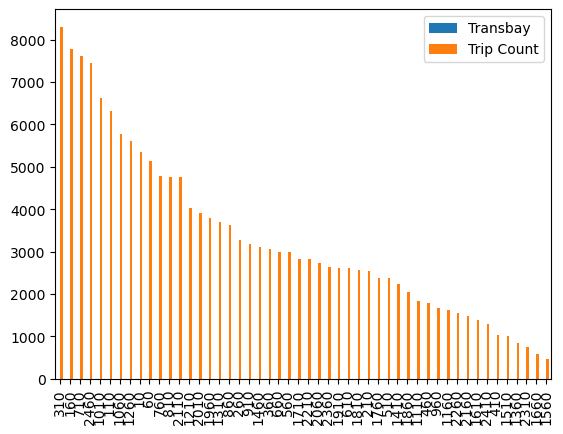

In [965]:
top_routes[top_routes['Destination Station']=='POWL'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Destination Station']=='EMBR'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Destination Station']=='MONT'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')
top_routes[top_routes['Destination Station']=='CIVC'].sort_values(by='Trip Count', ascending = False).plot(kind = 'bar')

In [71]:
#Monthly Top Trips (Destination is SF Downtown)
top_routes[top_routes['Destination Station'].isin(SF_downton)].sort_values(by='Trip Count', ascending = False).head(20)

print('Percent Origin of Destination SF Downtown ' + str(top_routes[top_routes['Origin Station'].isin(SF_downton)]['Trip Count'].sum()\
                                                         /top_routes[top_routes['Destination Station'].isin(SF_downton)]\
                                                         ['Trip Count'].sum()))

Percent Origin of Destination SF Downtown 0.9732786532885281


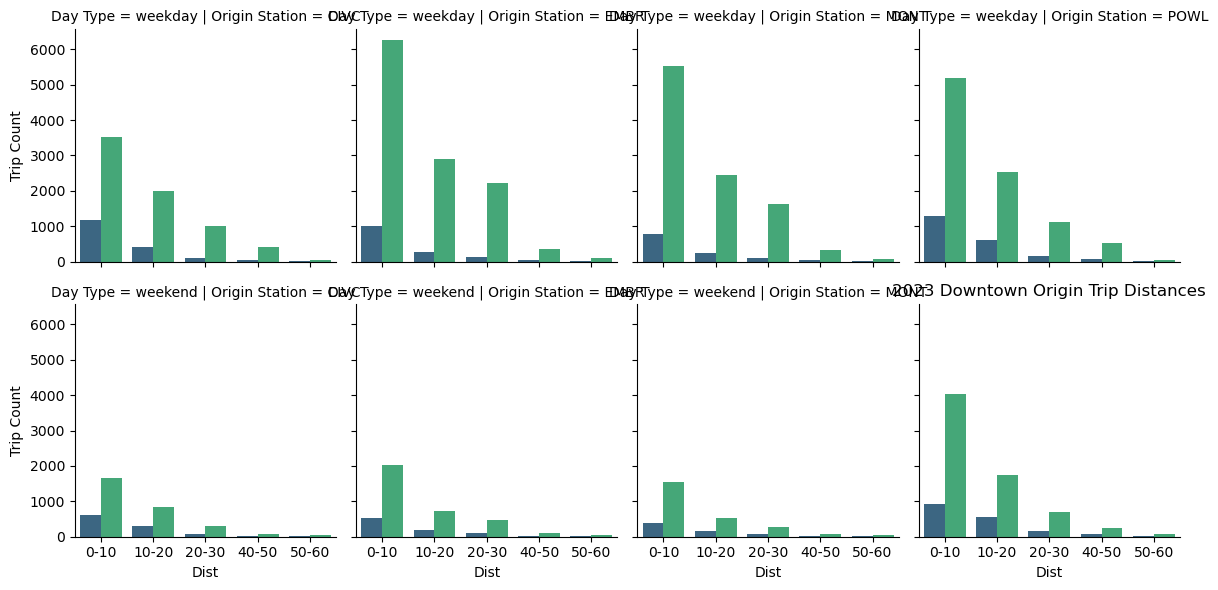

In [77]:
#Origin downtown day type dist
day_dist = df2023route.groupby(
    ['Month', 'Day Type','Hour','Origin Station','Destination Station','Long_x','Lat_x','Long_y','Lat_y']
)['Trip Count'].mean().reset_index()
day_dist = day_dist.groupby(
    ['Day Type','Hour','Origin Station','Destination Station','Long_x','Lat_x','Long_y','Lat_y'])['Trip Count'].mean().reset_index()
day_dist['O Coor'] = list(zip(pd.Series(zip(day_dist['Lat_x'].to_list(), day_dist['Long_x'].to_list())),
                                 pd.Series(zip(day_dist['Lat_y'].to_list(), day_dist['Long_y'].to_list()))))
day_dist['Dist_miles'] = day_dist['O Coor'].apply(lambda x: geopy.distance.geodesic(x[0], x[1]).miles)
day_dist['Dist'] = np.where(day_dist['Dist_miles']<10, '0-10',
                        np.where(day_dist['Dist_miles']<20, '10-20',
                        np.where(day_dist['Dist_miles']<30, '20-30',
                        np.where(day_dist['Dist_miles']<40, '40-50', '50-60'))))
day_dist_O = day_dist[day_dist['Origin Station'].isin(SF_downton)]
day_dist_O
g = sns.FacetGrid(day_dist_O.groupby(['Day Type','Origin Station','Hour','Dist'])['Trip Count'].sum().reset_index(), 
                  row = 'Day Type', col = 'Origin Station')
g.map_dataframe(sns.barplot,x='Dist',y='Trip Count', hue='Hour', palette = 'viridis')
plt.title('2023 Downtown Origin Trip Distances')
plt.savefig("images/2023_O_break.svg")
plt.savefig("images/2023_O_break.png")


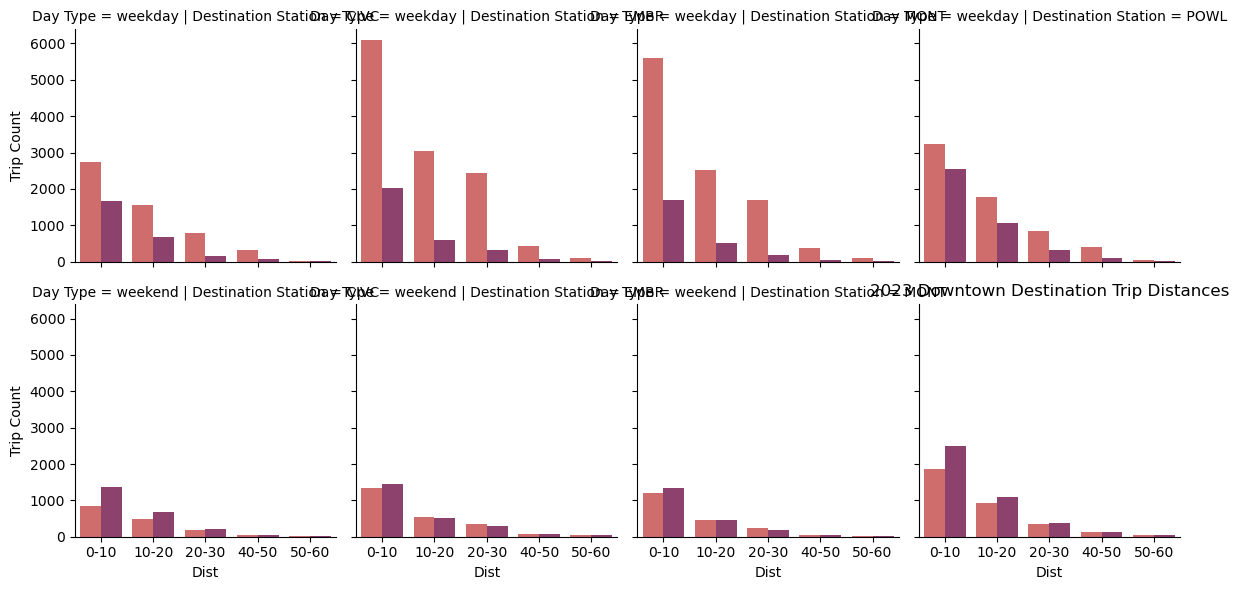

In [74]:
day_dist_D = day_dist[day_dist['Destination Station'].isin(SF_downton)]
g = sns.FacetGrid(day_dist_D.groupby(['Day Type','Destination Station','Hour','Dist'])['Trip Count'].sum().reset_index(), 
                  row = 'Day Type', col = 'Destination Station')
g.map_dataframe(sns.barplot,x='Dist',y='Trip Count', hue='Hour', palette = 'flare')
plt.title('2023 Downtown Destination Trip Distances')
plt.savefig("images/2023_D_break.svg")
plt.savefig("images/2023_D_break.png")

#Checking Numbers
# (day_dist_D.groupby(['Day Type','Destination Station','Hour','Dist'])['Trip Count'].sum().reset_index().groupby(
#     'Day Type')['Trip Count'].sum().reset_index().loc[0,'Trip Count']*20 + day_dist_D.groupby(
#     ['Day Type','Destination Station','Hour','Dist'])['Trip Count'].sum().reset_index().groupby(
#     'Day Type')['Trip Count'].sum().reset_index().loc[1,'Trip Count']*8)*4

In [78]:
day_dist_OD = pd.concat([day_dist_D.groupby(['Day Type','Destination Station','Hour','Dist'])['Trip Count'].sum().reset_index(),
          day_dist_O.groupby(['Day Type','Origin Station','Hour','Dist'])['Trip Count'].sum().reset_index()])
day_dist_OD['Type'] = day_dist_OD['Origin Station']
day_dist_OD['Type'] = day_dist_OD['Type'].fillna('Destination')
day_dist_OD.loc[day_dist_OD['Destination Station'].isna(), 'Type'] = 'Origin'
day_dist_OD['Destination Station'] = day_dist_OD['Destination Station'].fillna(day_dist_OD['Origin Station'])
day_dist_OD = day_dist_OD.drop(columns = 'Origin Station').rename(columns = ({'Destination Station':'Station'}))
day_dist_OD

Day Type Station Hour   Dist   Trip Count         Type
0   weekday    CIVC   AM   0-10  2739.586601  Destination
1   weekday    CIVC   AM  10-20  1561.322324  Destination
2   weekday    CIVC   AM  20-30   776.389368  Destination
3   weekday    CIVC   AM  40-50   317.287115  Destination
4   weekday    CIVC   AM  50-60    25.516877  Destination
..      ...     ...  ...    ...          ...          ...
75  weekend    POWL   PM   0-10  4045.562500       Origin
76  weekend    POWL   PM  10-20  1756.545635       Origin
77  weekend    POWL   PM  20-30   687.445833       Origin
78  weekend    POWL   PM  40-50   233.932639       Origin
79  weekend    POWL   PM  50-60    75.400694       Origin

[160 rows x 6 columns]

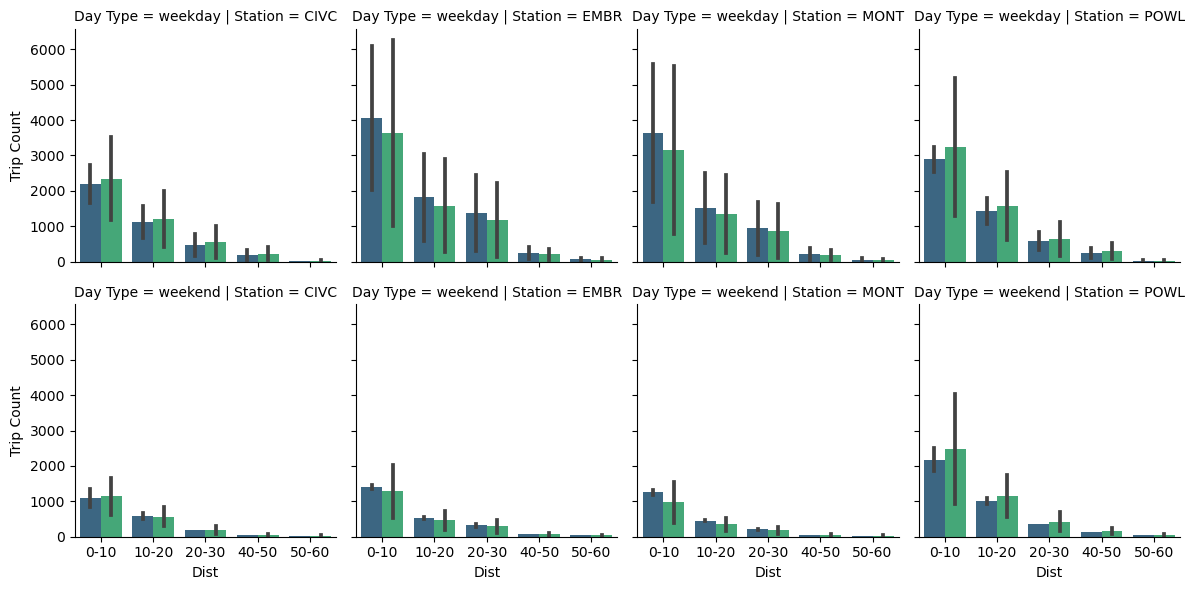

In [79]:
g = sns.FacetGrid(day_dist_OD, 
                  row = 'Day Type', col = 'Station')
g.map_dataframe(sns.barplot,x='Dist',y='Trip Count', hue='Type', palette = 'viridis')
